#Wine Quality Dataset for classification

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=6f6fc43df66cdb97779171e456b5d6ac9b9b48da154a0627786b8959b01c2322
  Stored in directory: /root/.cache/pip/wheels/98/25/f0/ab5adf3c6041d02e08073e288b6daf66206788126fdc60b442
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [2]:
#The dataset is so imbalanced that we need to avoid this warning because its too annoying.
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [4]:
dataset='wqc'
plot_dataset='WQC'

#Download the dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)

X = wine_quality.data.features
y = wine_quality.data.targets

#Show the data
print(X.head())



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'quality'


df=pd.concat([X, y], axis=1)

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
{'uci_id

In [5]:
#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
#mis_col = []
#df[mis_col] = df[mis_col].fillna(df.mean())


fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [6]:
# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3, seed=42)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7, seed=42)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create DataFrames for the splits
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

quality                 1.000000
alcohol                 0.438457
density                 0.292773
volatile_acidity        0.277925
chlorides               0.194056
citric_acid             0.090079
fixed_acidity           0.076022
sulphates               0.068103
free_sulfur_dioxide     0.065538
total_sulfur_dioxide    0.037923
residual_sugar          0.029202
pH                      0.018818
dtype: float64


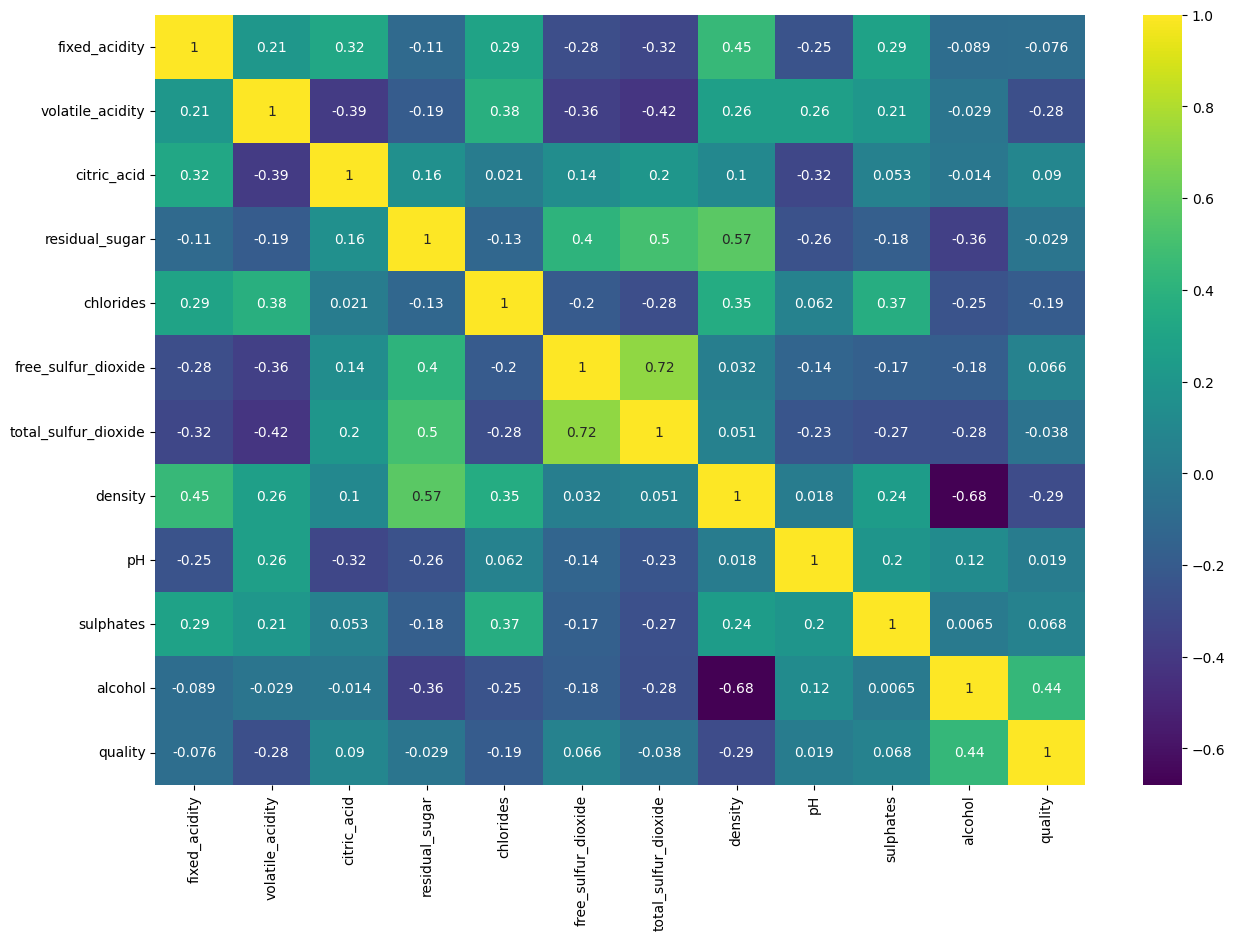

In [7]:
##Preprocessing

#Correlation of all features with the target
corr_mat = train_df.corr()[dep_var]
target_corr = np.abs(train_df.corrwith(train_df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = train_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()


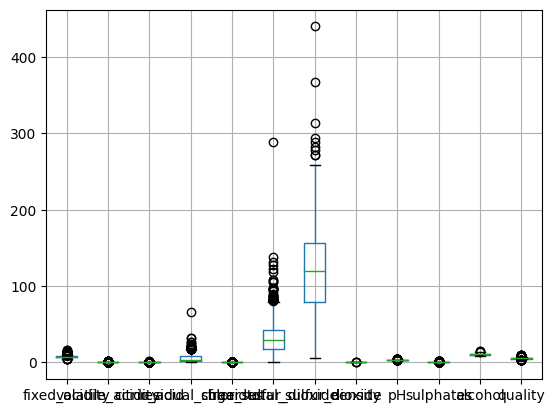

In [8]:
#Boxplot to see the range of feature values
train_df.boxplot()
plt.show()

In [9]:
#Drop features with low correlation with the target
features_to_drop = target_corr[target_corr < 0.05].index
train_df = train_df.drop(columns=features_to_drop)
val_df = val_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)
cont_names = [col for col in cont_names if col not in features_to_drop]
print(f"Variables eliminadas: {features_to_drop}")

Variables eliminadas: Index(['residual_sugar', 'total_sulfur_dioxide', 'pH'], dtype='object')


In [10]:
# Correlation matrix of the training set
corr_matrix = train_df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()

for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrames
train_df.drop(columns=to_drop, inplace=True)
val_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

# Update the list of continuous names
cont_names = [col for col in cont_names if col not in to_drop]

# Print the dropped features for reference
print(f"Variables eliminadas: {to_drop}")

Variables eliminadas: set()


In [11]:
def remove_outliers(df, factor):
    for col in df:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR= Q3-Q1
    
        lim_inf = Q1 - factor*IQR
        lim_sup = Q3 + factor*IQR

        #Nos quedamos con los datos que no sean outliers con calidad 5,6,7 y con los datos con calidad 3,4,8,9 independientemente de si son outliers
        df = df[((df[col] >= lim_inf) & (df[col] <= lim_sup)) | (df['quality'].isin([3,4,8,9]))]
    return df

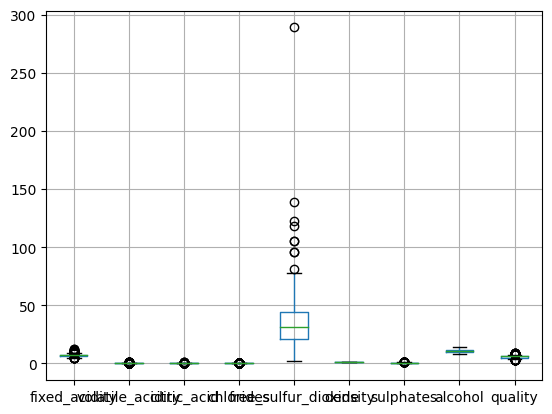

In [12]:
train_df_no_outliers = remove_outliers(train_df, 1.5)

train_df_no_outliers.boxplot()
plt.show()

In [13]:
# Normalize the continuous features
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
train_df_no_outliers.loc[:,cont_names] = scaler.fit_transform(train_df_no_outliers.loc[:,cont_names])

# Transform the validation and test data
val_df.loc[:,cont_names] = scaler.transform(val_df.loc[:,cont_names])
test_df.loc[:,cont_names] = scaler.transform(test_df.loc[:,cont_names])


train_df_no_outliers = train_df_no_outliers.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Combine all indices for the splits
splits = (list(train_df_no_outliers.index), list(val_df.index))

# Concatenate the DataFrames back together
df_c = pd.concat([train_df_no_outliers, val_df])

# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

# Create TabularPandas for the test set
test_to = TabularPandas(
    test_df,  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)
dls.to(device)
test_dl.to(device)

In [14]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
names_layer=['1 capa', '2 capas', '5 capas', '11 capas']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['BalAcc']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [15]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=10, metrics=utilsTFG.balanced_accuracy_func, loss_func=CrossEntropyLossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 10             
Linear                                    650        True      
____________________________________________________________________________

Total params: 1,306
Total trainable params: 1,306
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fb2e029f240>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Cas

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 10             
Linear                                    650        True      
____________________________________________________________________________

Total params: 5,530
Total train

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     64 x 256            
Linear                                    32768      T

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8              
BatchNorm1d                               16         True      
____________________________________________________________________________
                     64 x 32             
Linear                                    256        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       T

## Gradient Descent

In [16]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=utilsTFG.balanced_accuracy_func, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [17]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 2.441047430038452.
Better model found at epoch 1 with valid_loss value: 1.8329222202301025.
Better model found at epoch 2 with valid_loss value: 1.5195201635360718.
Better model found at epoch 3 with valid_loss value: 1.3488141298294067.
Better model found at epoch 4 with valid_loss value: 1.2696936130523682.
Better model found at epoch 5 with valid_loss value: 1.229875922203064.
Better model found at epoch 6 with valid_loss value: 1.2045420408248901.
Better model found at epoch 7 with valid_loss value: 1.1754000186920166.
Better model found at epoch 8 with valid_loss value: 1.157644271850586.
Better model found at epoch 9 with valid_loss value: 1.140316367149353.
Better model found at epoch 10 with valid_loss value: 1.1338071823120117.
Better model found at epoch 11 with valid_loss value: 1.1309572458267212.
Better model found at epoch 12 with valid_loss value: 1.1156941652297974.
Better model found at epoch 13 with valid_loss value

Better model found at epoch 0 with valid_loss value: 2.1203341484069824.
Better model found at epoch 1 with valid_loss value: 1.6424447298049927.
Better model found at epoch 2 with valid_loss value: 1.3739045858383179.
Better model found at epoch 3 with valid_loss value: 1.2328294515609741.
Better model found at epoch 4 with valid_loss value: 1.157881498336792.
Better model found at epoch 5 with valid_loss value: 1.125806212425232.
Better model found at epoch 6 with valid_loss value: 1.0993572473526.
Better model found at epoch 7 with valid_loss value: 1.065694808959961.
Better model found at epoch 8 with valid_loss value: 1.0438182353973389.
Better model found at epoch 9 with valid_loss value: 1.022201657295227.
Better model found at epoch 11 with valid_loss value: 1.0103449821472168.
Better model found at epoch 12 with valid_loss value: 0.9967098236083984.
Better model found at epoch 13 with valid_loss value: 0.9921919703483582.
Better model found at epoch 14 with valid_loss value: 0

Better model found at epoch 0 with valid_loss value: 2.0314018726348877.
Better model found at epoch 1 with valid_loss value: 1.460448145866394.
Better model found at epoch 2 with valid_loss value: 1.184706449508667.
Better model found at epoch 3 with valid_loss value: 1.0443401336669922.
Better model found at epoch 4 with valid_loss value: 0.9281049966812134.
Better model found at epoch 5 with valid_loss value: 0.8721129298210144.
Better model found at epoch 6 with valid_loss value: 0.8421419858932495.
Better model found at epoch 7 with valid_loss value: 0.7893543839454651.
Better model found at epoch 8 with valid_loss value: 0.7703587412834167.
Better model found at epoch 9 with valid_loss value: 0.6986852288246155.
Better model found at epoch 11 with valid_loss value: 0.6904453635215759.
Better model found at epoch 12 with valid_loss value: 0.6539831161499023.
Better model found at epoch 13 with valid_loss value: 0.6495217084884644.
Better model found at epoch 14 with valid_loss val

Better model found at epoch 0 with valid_loss value: 2.1112287044525146.
Better model found at epoch 1 with valid_loss value: 1.4563504457473755.
Better model found at epoch 2 with valid_loss value: 1.1614362001419067.
Better model found at epoch 3 with valid_loss value: 1.0099937915802002.
Better model found at epoch 4 with valid_loss value: 0.9785927534103394.
Better model found at epoch 5 with valid_loss value: 0.9470747113227844.
Better model found at epoch 6 with valid_loss value: 0.897786021232605.
Better model found at epoch 7 with valid_loss value: 0.8257933259010315.
Better model found at epoch 8 with valid_loss value: 0.7904225587844849.
Better model found at epoch 9 with valid_loss value: 0.7507011890411377.
Better model found at epoch 10 with valid_loss value: 0.7462899088859558.
Better model found at epoch 11 with valid_loss value: 0.6929023265838623.
Better model found at epoch 12 with valid_loss value: 0.6812717914581299.
Better model found at epoch 13 with valid_loss va

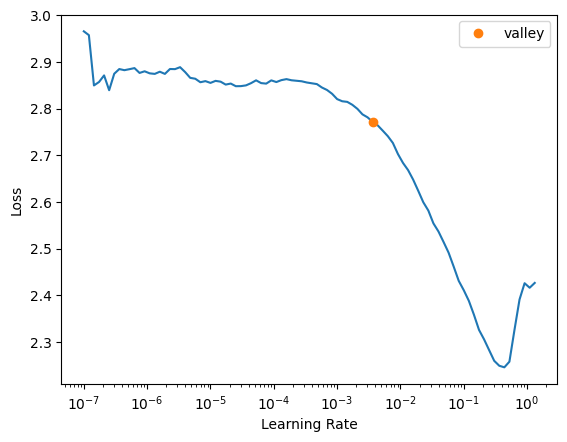

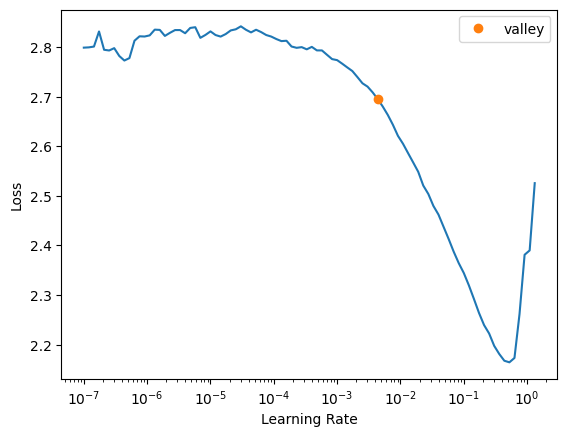

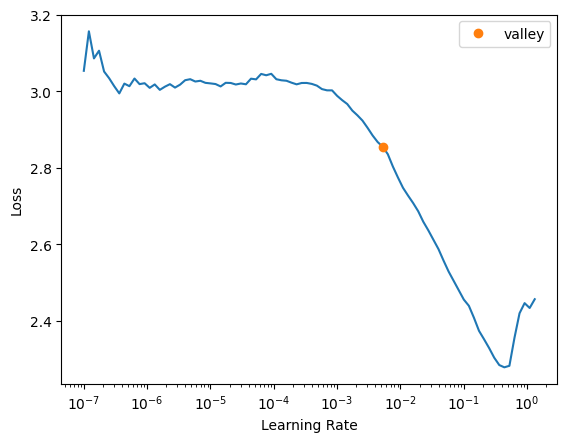

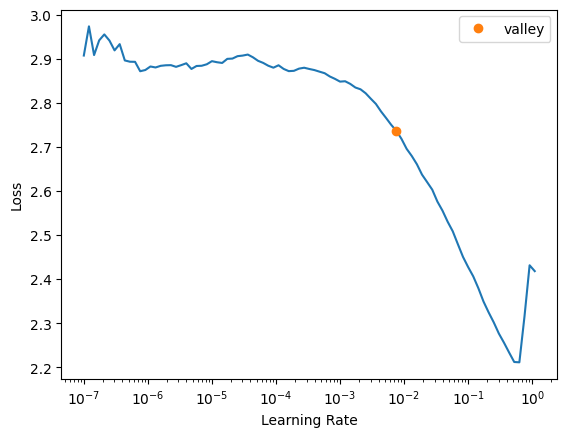

In [18]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



<Figure size 1200x600 with 0 Axes>

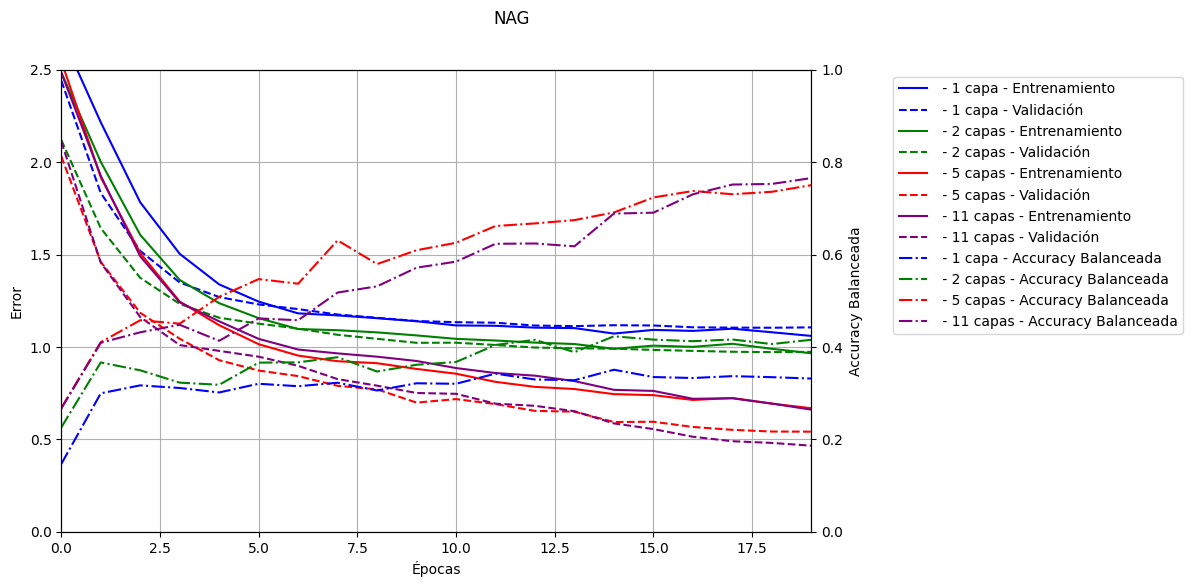

In [19]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title='NAG', lim= 2.5, names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 1.4258147478103638.
Better model found at epoch 1 with valid_loss value: 1.137999176979065.
Better model found at epoch 3 with valid_loss value: 1.1169630289077759.
Better model found at epoch 4 with valid_loss value: 1.0926799774169922.
Better model found at epoch 7 with valid_loss value: 1.0654258728027344.
Better model found at epoch 9 with valid_loss value: 1.0468677282333374.
Better model found at epoch 13 with valid_loss value: 1.0438549518585205.
Better model found at epoch 16 with valid_loss value: 1.0364052057266235.
Better model found at epoch 17 with valid_loss value: 1.0340131521224976.
Better model found at epoch 18 with valid_loss value: 1.0338997840881348.
Better model found at epoch 19 with valid_loss value: 1.033077597618103.


Better model found at epoch 0 with valid_loss value: 1.430466890335083.
Better model found at epoch 1 with valid_loss value: 1.1166770458221436.
Better model found at epoch 2 with valid_loss value: 1.082869052886963.
Better model found at epoch 3 with valid_loss value: 1.0368502140045166.
Better model found at epoch 4 with valid_loss value: 1.031803846359253.
Better model found at epoch 5 with valid_loss value: 1.0140643119812012.
Better model found at epoch 7 with valid_loss value: 0.9784702658653259.
Better model found at epoch 8 with valid_loss value: 0.9680599570274353.
Better model found at epoch 9 with valid_loss value: 0.9302563071250916.
Better model found at epoch 12 with valid_loss value: 0.9187129735946655.
Better model found at epoch 13 with valid_loss value: 0.9039220213890076.
Better model found at epoch 14 with valid_loss value: 0.8740336894989014.
Better model found at epoch 16 with valid_loss value: 0.8530584573745728.
Better model found at epoch 17 with valid_loss val

Better model found at epoch 0 with valid_loss value: 1.327269196510315.
Better model found at epoch 1 with valid_loss value: 1.040908932685852.
Better model found at epoch 5 with valid_loss value: 1.0019069910049438.
Better model found at epoch 7 with valid_loss value: 0.9631640911102295.
Better model found at epoch 9 with valid_loss value: 0.9278521537780762.
Better model found at epoch 12 with valid_loss value: 0.8865739107131958.
Better model found at epoch 13 with valid_loss value: 0.8747134804725647.
Better model found at epoch 14 with valid_loss value: 0.8178528547286987.
Better model found at epoch 15 with valid_loss value: 0.7855848073959351.
Better model found at epoch 16 with valid_loss value: 0.7639787793159485.
Better model found at epoch 17 with valid_loss value: 0.7087546586990356.
Better model found at epoch 18 with valid_loss value: 0.6929664611816406.
Better model found at epoch 19 with valid_loss value: 0.6774001717567444.


Better model found at epoch 0 with valid_loss value: 1.478045105934143.
Better model found at epoch 1 with valid_loss value: 1.160494327545166.
Better model found at epoch 2 with valid_loss value: 1.143367886543274.
Better model found at epoch 5 with valid_loss value: 1.1107385158538818.
Better model found at epoch 6 with valid_loss value: 1.1087993383407593.
Better model found at epoch 7 with valid_loss value: 1.0757980346679688.
Better model found at epoch 8 with valid_loss value: 1.0744409561157227.
Better model found at epoch 10 with valid_loss value: 1.0504270792007446.
Better model found at epoch 14 with valid_loss value: 1.0484999418258667.
Better model found at epoch 15 with valid_loss value: 1.0107169151306152.
Better model found at epoch 17 with valid_loss value: 0.9850821495056152.
Better model found at epoch 18 with valid_loss value: 0.979689359664917.
Better model found at epoch 19 with valid_loss value: 0.9667304158210754.


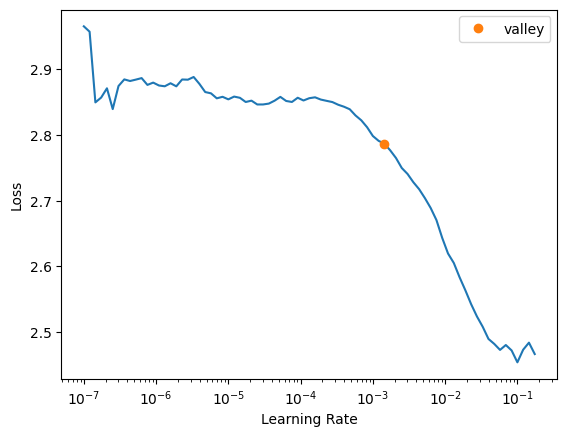

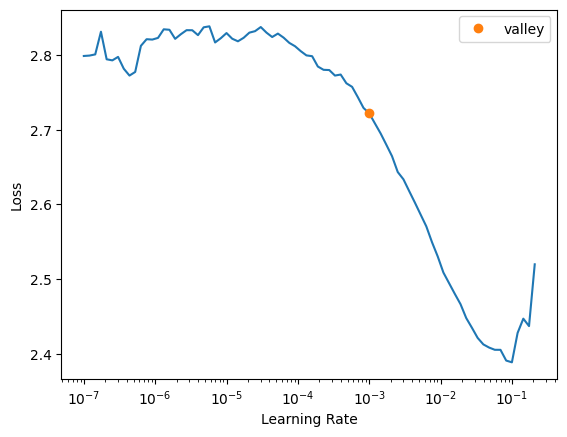

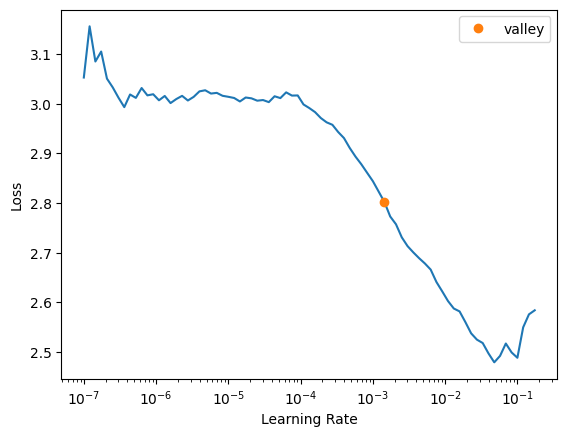

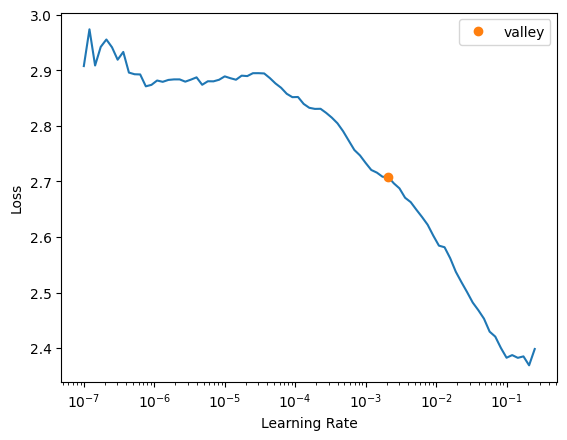

In [20]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

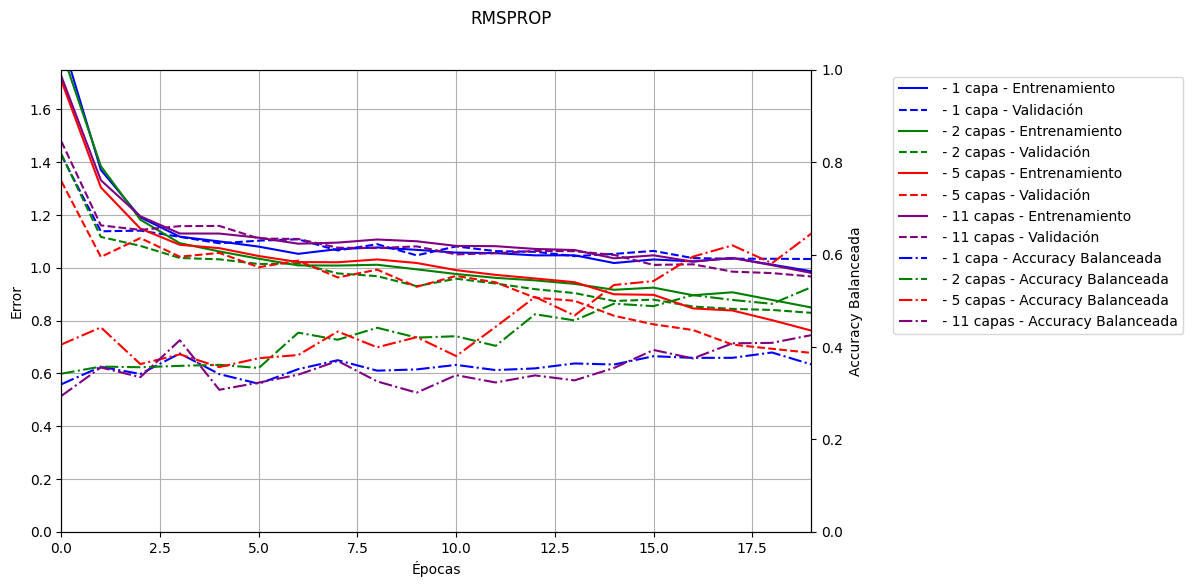

In [21]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='RMSPROP', lim= 1.75, names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 2.496635675430298.
Better model found at epoch 1 with valid_loss value: 1.9560644626617432.
Better model found at epoch 2 with valid_loss value: 1.4888768196105957.
Better model found at epoch 3 with valid_loss value: 1.2180991172790527.
Better model found at epoch 4 with valid_loss value: 1.1374400854110718.
Better model found at epoch 5 with valid_loss value: 1.1160190105438232.
Better model found at epoch 6 with valid_loss value: 1.1099128723144531.
Better model found at epoch 7 with valid_loss value: 1.082457184791565.
Better model found at epoch 8 with valid_loss value: 1.0751417875289917.
Better model found at epoch 9 with valid_loss value: 1.0585198402404785.
Better model found at epoch 12 with valid_loss value: 1.0494698286056519.
Better model found at epoch 16 with valid_loss value: 1.0465682744979858.
Better model found at epoch 17 with valid_loss value: 1.0444611310958862.


Better model found at epoch 0 with valid_loss value: 2.192678451538086.
Better model found at epoch 1 with valid_loss value: 1.8103638887405396.
Better model found at epoch 2 with valid_loss value: 1.4794774055480957.
Better model found at epoch 3 with valid_loss value: 1.1940208673477173.
Better model found at epoch 4 with valid_loss value: 1.0769644975662231.
Better model found at epoch 5 with valid_loss value: 1.0303162336349487.
Better model found at epoch 6 with valid_loss value: 1.0191510915756226.
Better model found at epoch 7 with valid_loss value: 0.9898290634155273.
Better model found at epoch 8 with valid_loss value: 0.9577952027320862.
Better model found at epoch 9 with valid_loss value: 0.9380612969398499.
Better model found at epoch 11 with valid_loss value: 0.9379574060440063.
Better model found at epoch 12 with valid_loss value: 0.9120490550994873.
Better model found at epoch 14 with valid_loss value: 0.9088382124900818.
Better model found at epoch 15 with valid_loss va

Better model found at epoch 0 with valid_loss value: 2.0683271884918213.
Better model found at epoch 1 with valid_loss value: 1.6310808658599854.
Better model found at epoch 2 with valid_loss value: 1.3452140092849731.
Better model found at epoch 3 with valid_loss value: 1.1373330354690552.
Better model found at epoch 4 with valid_loss value: 0.9682232141494751.
Better model found at epoch 5 with valid_loss value: 0.9082368016242981.
Better model found at epoch 6 with valid_loss value: 0.8915894627571106.
Better model found at epoch 7 with valid_loss value: 0.7807525992393494.
Better model found at epoch 9 with valid_loss value: 0.7239899039268494.
Better model found at epoch 11 with valid_loss value: 0.6965815424919128.
Better model found at epoch 12 with valid_loss value: 0.6417426466941833.
Better model found at epoch 13 with valid_loss value: 0.627923846244812.
Better model found at epoch 14 with valid_loss value: 0.5577870011329651.
Better model found at epoch 15 with valid_loss v

Better model found at epoch 0 with valid_loss value: 2.0483248233795166.
Better model found at epoch 1 with valid_loss value: 1.6754858493804932.
Better model found at epoch 2 with valid_loss value: 1.4141221046447754.
Better model found at epoch 3 with valid_loss value: 1.1245232820510864.
Better model found at epoch 4 with valid_loss value: 1.0316519737243652.
Better model found at epoch 5 with valid_loss value: 1.0313042402267456.
Better model found at epoch 6 with valid_loss value: 0.9974524974822998.
Better model found at epoch 7 with valid_loss value: 0.9470682144165039.
Better model found at epoch 8 with valid_loss value: 0.8833625316619873.
Better model found at epoch 9 with valid_loss value: 0.875339925289154.
Better model found at epoch 11 with valid_loss value: 0.8511254191398621.
Better model found at epoch 12 with valid_loss value: 0.8170294165611267.
Better model found at epoch 13 with valid_loss value: 0.7560859322547913.
Better model found at epoch 14 with valid_loss va

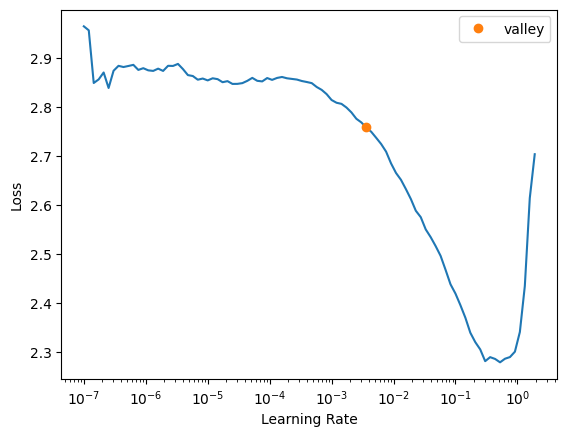

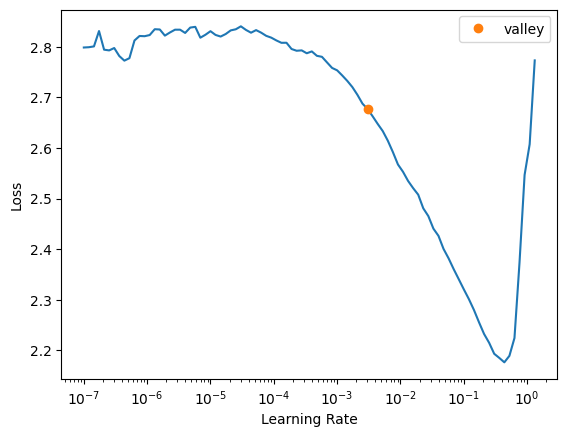

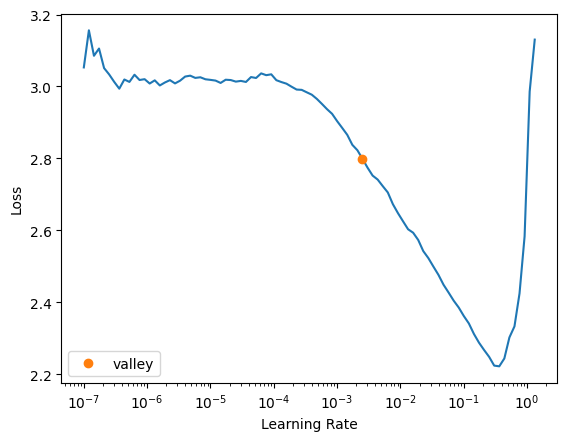

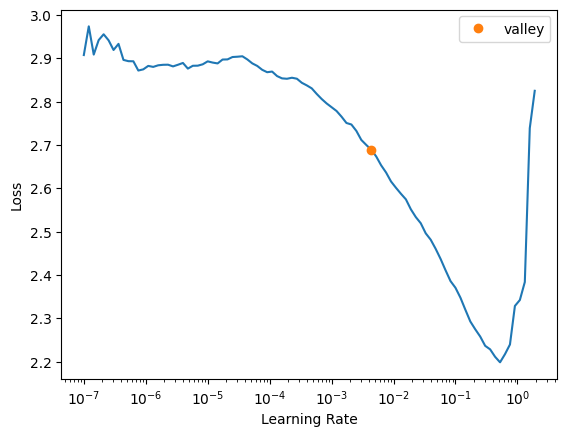

In [22]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

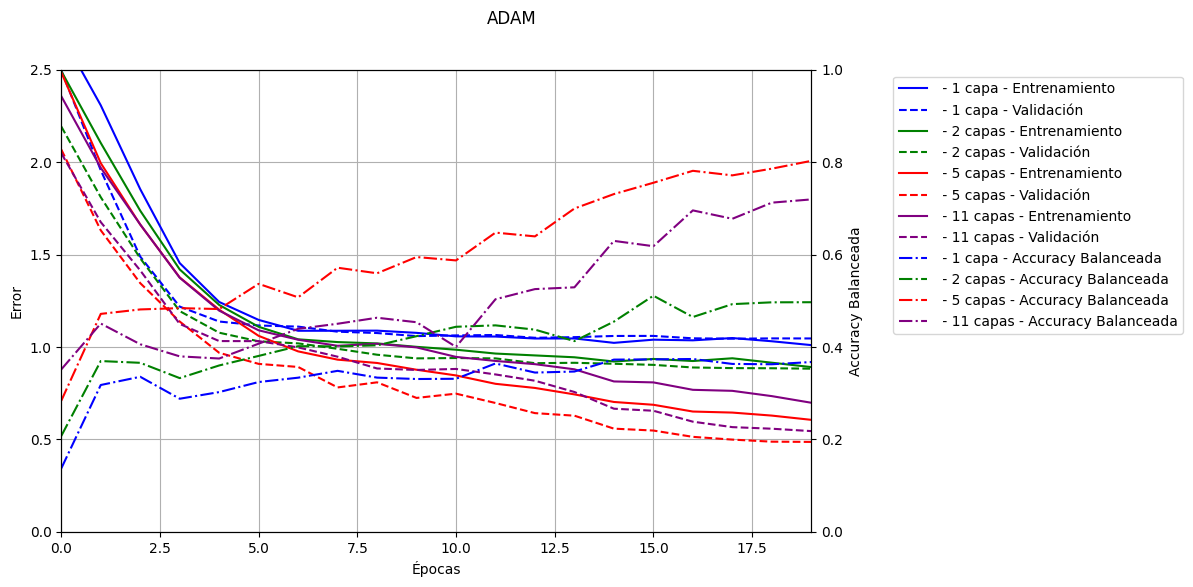

In [23]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='ADAM', lim= 2.5, names=names_layer, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 2.6260886192321777.
Better model found at epoch 1 with valid_loss value: 2.4495046138763428.
Better model found at epoch 2 with valid_loss value: 2.2607154846191406.
Better model found at epoch 3 with valid_loss value: 2.0728259086608887.
Better model found at epoch 4 with valid_loss value: 1.8812789916992188.
Better model found at epoch 5 with valid_loss value: 1.7327183485031128.
Better model found at epoch 6 with valid_loss value: 1.542461633682251.
Better model found at epoch 7 with valid_loss value: 1.3747738599777222.
Better model found at epoch 8 with valid_loss value: 1.257598638534546.
Better model found at epoch 9 with valid_loss value: 1.1881839036941528.
Better model found at epoch 10 with valid_loss value: 1.1482224464416504.
Better model found at epoch 11 with valid_loss value: 1.1356816291809082.
Better model found at epoch 12 with valid_loss value: 1.1013057231903076.
Better model found at epoch 13 with valid_loss val

Better model found at epoch 0 with valid_loss value: 2.3331894874572754.
Better model found at epoch 1 with valid_loss value: 2.181551694869995.
Better model found at epoch 2 with valid_loss value: 2.007642984390259.
Better model found at epoch 3 with valid_loss value: 1.846516728401184.
Better model found at epoch 4 with valid_loss value: 1.7075289487838745.
Better model found at epoch 5 with valid_loss value: 1.614271879196167.
Better model found at epoch 6 with valid_loss value: 1.4798246622085571.
Better model found at epoch 7 with valid_loss value: 1.3438398838043213.
Better model found at epoch 8 with valid_loss value: 1.228906512260437.
Better model found at epoch 9 with valid_loss value: 1.1368075609207153.
Better model found at epoch 10 with valid_loss value: 1.084742784500122.
Better model found at epoch 11 with valid_loss value: 1.0527082681655884.
Better model found at epoch 12 with valid_loss value: 1.009212613105774.
Better model found at epoch 13 with valid_loss value: 0

Better model found at epoch 0 with valid_loss value: 2.289435625076294.
Better model found at epoch 1 with valid_loss value: 1.9794076681137085.
Better model found at epoch 2 with valid_loss value: 1.8017584085464478.
Better model found at epoch 3 with valid_loss value: 1.6702944040298462.
Better model found at epoch 4 with valid_loss value: 1.444106936454773.
Better model found at epoch 5 with valid_loss value: 1.335559606552124.
Better model found at epoch 6 with valid_loss value: 1.2449951171875.
Better model found at epoch 7 with valid_loss value: 1.1165763139724731.
Better model found at epoch 8 with valid_loss value: 1.0252395868301392.
Better model found at epoch 9 with valid_loss value: 0.899573802947998.
Better model found at epoch 10 with valid_loss value: 0.8932639360427856.
Better model found at epoch 11 with valid_loss value: 0.8903009295463562.
Better model found at epoch 12 with valid_loss value: 0.8141271471977234.
Better model found at epoch 13 with valid_loss value: 0

Better model found at epoch 0 with valid_loss value: 2.124478578567505.
Better model found at epoch 1 with valid_loss value: 1.84187912940979.
Better model found at epoch 2 with valid_loss value: 1.6444790363311768.
Better model found at epoch 3 with valid_loss value: 1.5073299407958984.
Better model found at epoch 4 with valid_loss value: 1.3510267734527588.
Better model found at epoch 5 with valid_loss value: 1.3068736791610718.
Better model found at epoch 6 with valid_loss value: 1.173256754875183.
Better model found at epoch 7 with valid_loss value: 1.0280002355575562.
Better model found at epoch 9 with valid_loss value: 0.9582604169845581.
Better model found at epoch 10 with valid_loss value: 0.9205819964408875.
Better model found at epoch 11 with valid_loss value: 0.9126927256584167.
Better model found at epoch 12 with valid_loss value: 0.880923867225647.
Better model found at epoch 14 with valid_loss value: 0.8322281837463379.
Better model found at epoch 19 with valid_loss value

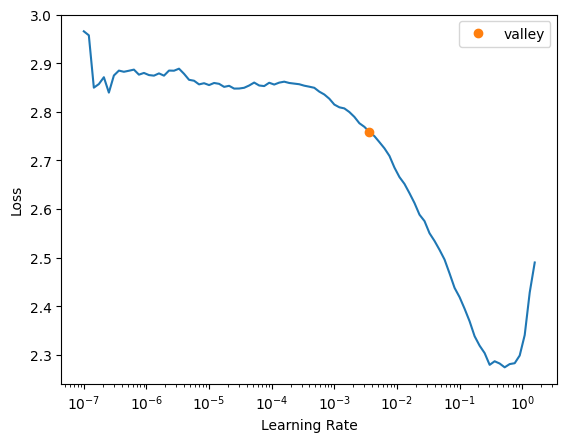

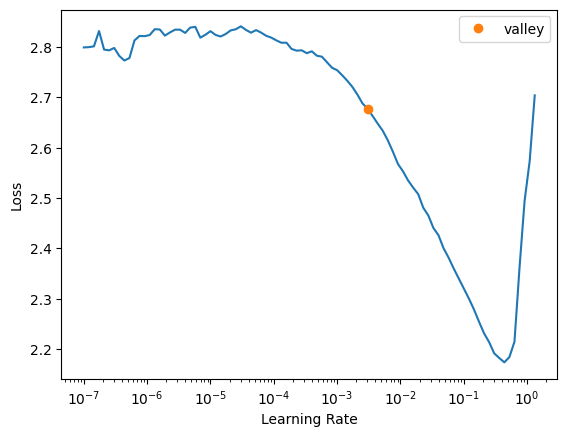

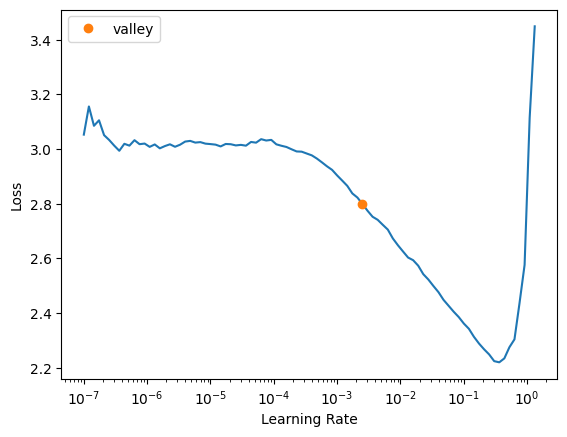

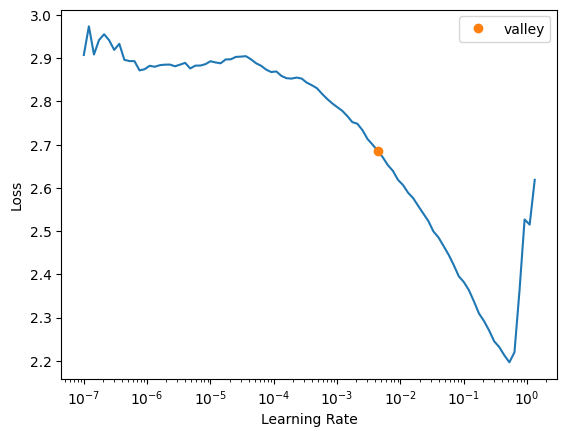

In [24]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(100, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][layer] = end-start

<Figure size 1200x600 with 0 Axes>

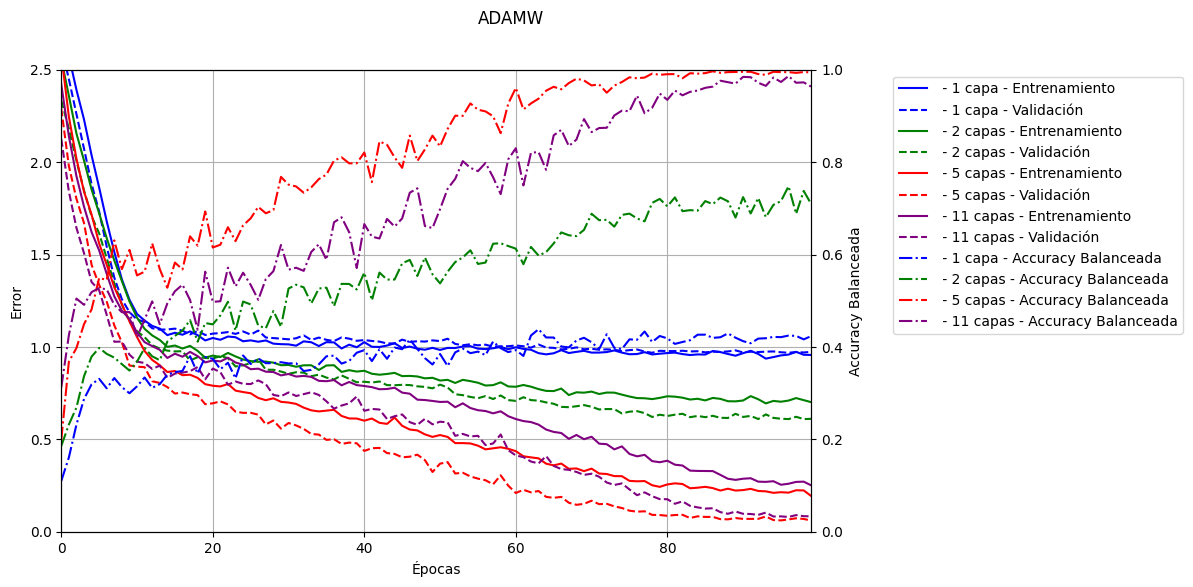

In [25]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), title='ADAMW', lim= 2.5, names=names_layer, metric=metric)

# Test

### Save or Load models

In [26]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [27]:
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)

In [21]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']
    
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)

### Comparative per layers

<Figure size 1200x600 with 0 Axes>

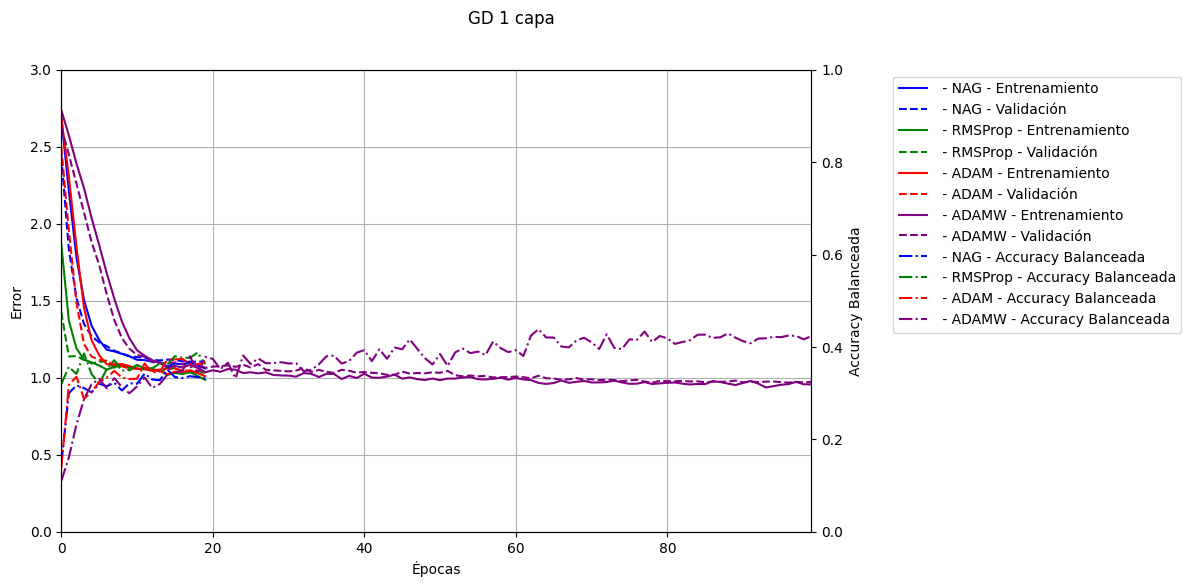

<Figure size 1200x600 with 0 Axes>

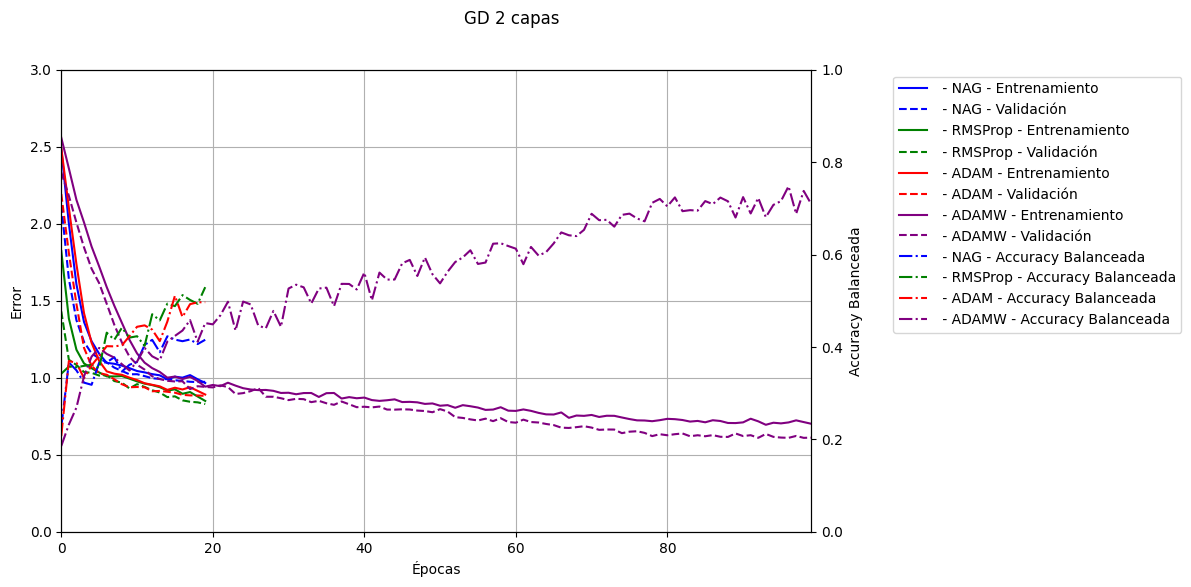

<Figure size 1200x600 with 0 Axes>

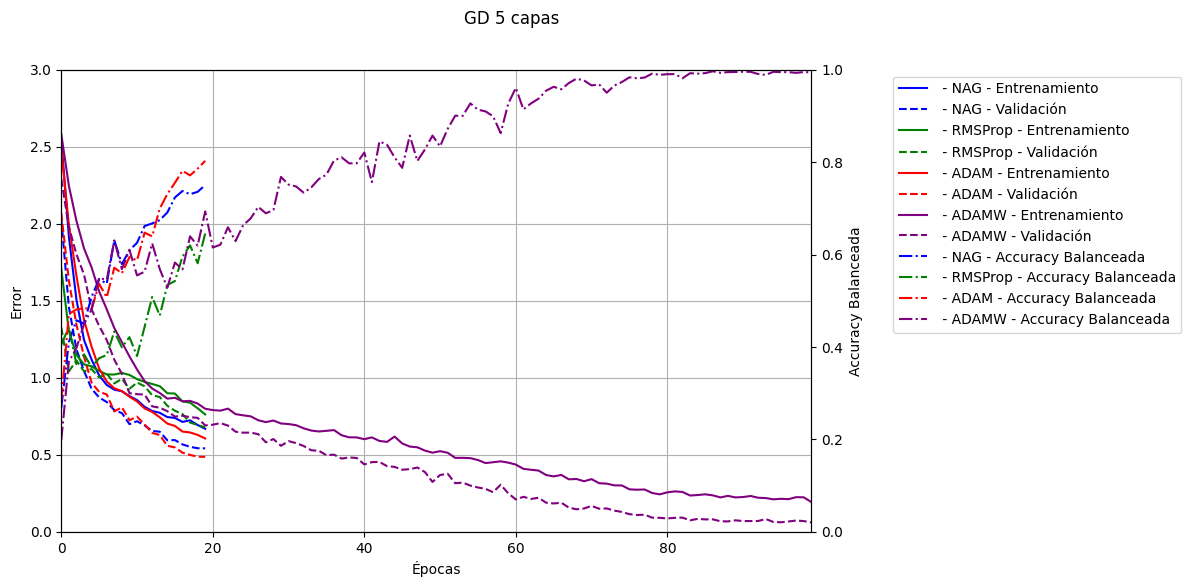

<Figure size 1200x600 with 0 Axes>

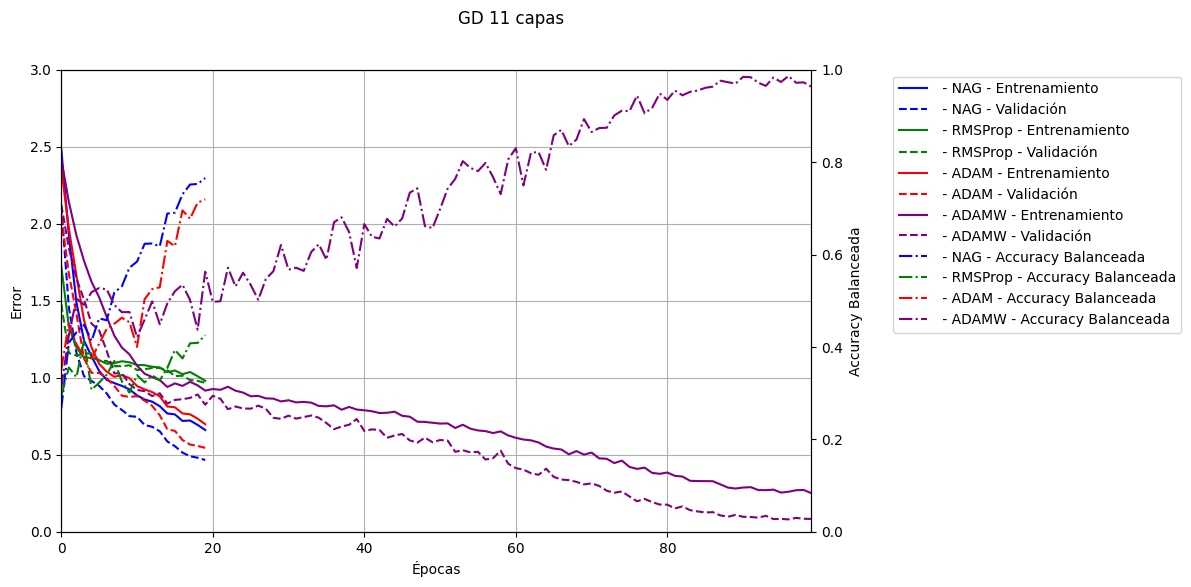

In [28]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1], learners['ADAMW'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2], learners['ADAMW'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5], learners['ADAMW'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11], learners['ADAMW'][11]]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_1_layer, title=f'GD 1 capa', lim= 3,  names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title=f'GD 2 capas', lim= 3, names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title=f'GD 5 capas',lim= 3,  names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title=f'GD 11 capas', lim= 3, names=names, metric=metric)

### Generalization

In [29]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Balanced Accuracy: {accuracy}")

Optimizer: NAG, Layers: 1, Loss: 1.534838318824768, Balanced Accuracy: 0.3380596445782418


Optimizer: NAG, Layers: 2, Loss: 2.105415105819702, Balanced Accuracy: 0.38625326783197905


Optimizer: NAG, Layers: 5, Loss: 3.2630879878997803, Balanced Accuracy: 0.4275041383326279


Optimizer: NAG, Layers: 11, Loss: 3.712068557739258, Balanced Accuracy: 0.49292735514676694


Optimizer: RMSProp, Layers: 1, Loss: 1.981793761253357, Balanced Accuracy: 0.3935749183601826


Optimizer: RMSProp, Layers: 2, Loss: 2.801039457321167, Balanced Accuracy: 0.47637378700447597


Optimizer: RMSProp, Layers: 5, Loss: 3.546476364135742, Balanced Accuracy: 0.45150627795540754


Optimizer: RMSProp, Layers: 11, Loss: 2.1932976245880127, Balanced Accuracy: 0.3677686869860008


Optimizer: ADAM, Layers: 1, Loss: 1.6522071361541748, Balanced Accuracy: 0.3668824328519811


Optimizer: ADAM, Layers: 2, Loss: 2.6059067249298096, Balanced Accuracy: 0.47502773029677425


Optimizer: ADAM, Layers: 5, Loss: 4.0130157470703125, Balanced Accuracy: 0.4954580448114638


Optimizer: ADAM, Layers: 11, Loss: 3.38507342338562, Balanced Accuracy: 0.49805328968983087


Optimizer: ADAMW, Layers: 1, Loss: 2.1721572875976562, Balanced Accuracy: 0.43591037511641


Optimizer: ADAMW, Layers: 2, Loss: 3.17730450630188, Balanced Accuracy: 0.5004292884733803


Optimizer: ADAMW, Layers: 5, Loss: 3.8335087299346924, Balanced Accuracy: 0.6058913734938889


Optimizer: ADAMW, Layers: 11, Loss: 3.8725638389587402, Balanced Accuracy: 0.6065348493964944


## Metaheuristics

In [30]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
utilsTFG.set_seed()

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  optim= RMSProp if n_layer==1 or n_layer==2 else ADAM
  mh_learners[n_layer] = tabular_learner(dls, n_out=10, loss_func=CrossEntropyLossFlat(), opt_func=optim, layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


In [34]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)

In [31]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [33]:
for alg in algs:
    file_path = f'/notebooks/saved_models/{alg}_dict_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        results[alg] = pickle.load(f)
    file_path = f'/notebooks/saved_models/{alg}_time_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        time_mh[alg] = pickle.load(f)

In [18]:
time_full_mh = {}
for alg in ['SHADE', 'SHADE-ILS']:
    time_full_mh[alg]= time_mh[alg]

### Genetic Algorithms

In [27]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [34]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)
    
file_path = f'/notebooks/saved_models/SHADE_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'], f)


In [34]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  start = time.perf_counter()
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))
  end = time.perf_counter()
  #time_full_mh['SHADE'][layer]+= end-start
  

In [35]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [2.791630744934082, 2.6449601650238037, 2.503519058227539, 2.503519058227539, 2.4645309448242188, 2.3840484619140625, 2.362680435180664, 2.308171033859253, 2.308171033859253, 2.2533059120178223, 2.2406129837036133, 2.2406129837036133, 2.239611864089966, 2.2198991775512695, 2.201791763305664, 2.1920666694641113, 2.1920666694641113, 2.1840157508850098, 2.145043134689331, 2.145043134689331, 2.145043134689331, 2.133470296859741, 2.133470296859741, 2.133470296859741, 2.133470296859741, 2.133470296859741, 2.133470296859741, 2.1140341758728027, 2.1140341758728027, 2.1000704765319824, 2.1000704765319824, 2.1000704765319824, 2.1000704765319824, 2.1000704765319824, 2.1000704765319824, 2.0957846641540527, 2.0957846641540527, 2.090160608291626, 2.0806477069854736, 2.0806477069854736, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959, 2.07749080657959,

In [32]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for layer in n_layers:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][layer])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][layer] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][layer] = [np.mean(fitness_valid['SHADE'][layer][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][layer]), 5)]

### SHADE-ILS

In [35]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)
file_path = f'/notebooks/saved_models/SHADE-ILS_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'], f)


deque([1, 1, 0.5919810216938362], maxlen=3)
236
deque([1, 0.5919810216938362, 0.01586372126017248], maxlen=3)
448
deque([0.5919810216938362, 0.01586372126017248, 0.001881559683555968], maxlen=3)
666
deque([0.01586372126017248, 0.001881559683555968, -0.0036821002557514237], maxlen=3)
Reiniciado
888
deque([1, 1, 0.2370650866507406], maxlen=3)
1104
deque([1, 0.2370650866507406, 0.0028725287953823833], maxlen=3)
1316
deque([0.2370650866507406, 0.0028725287953823833, -0.013376454178463976], maxlen=3)
1531
deque([0.0028725287953823833, -0.013376454178463976, 0.013900374993634581], maxlen=3)
Reiniciado
1757
deque([1, 1, 0.24603468384141217], maxlen=3)
1974
deque([1, 0.24603468384141217, 0.0011793705865018745], maxlen=3)
2186
deque([0.24603468384141217, 0.0011793705865018745, -0.001233200828580024], maxlen=3)
2398
deque([0.0011793705865018745, -0.001233200828580024, 0.00976043125321081], maxlen=3)
Reiniciado
2621
deque([1, 1, 0.19390103446875515], maxlen=3)
2835
deque([1, 0.19390103446875515, 

In [36]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  start = time.perf_counter()
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))
  end = time.perf_counter()
  #time_full_mh['SHADE-ILS'][layer] += end-start

In [37]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [2.791630744934082, 1.139038324356079, 1.1209689378738403, 1.1188597679138184, 1.1188597679138184, 1.1097038984298706, 1.1065162420272827, 1.1065162420272827, 1.1057307720184326, 1.1057307720184326, 1.1057307720184326, 1.1057307720184326, 1.097668170928955, 1.097668170928955, 1.097668170928955, 1.097668170928955, 1.097668170928955, 1.097668170928955, 1.097668170928955, 1.0932958126068115, 1.0932958126068115]
Validation error of SHADE-ILS for 1 layers: [2.3776516914367676, 1.2928285598754883, 1.2886240482330322, 1.2724021673202515, 1.2724021673202515, 1.2395046949386597, 1.2325334548950195, 1.2325334548950195, 1.2180222272872925, 1.2180222272872925, 1.2180222272872925, 1.2180222272872925, 1.215555191040039, 1.215555191040039, 1.215555191040039, 1.215555191040039, 1.215555191040039, 1.215555191040039, 1.215555191040039, 1.2496697902679443, 1.2496697902679443]
Difference: [-0.41397905  0.15379024  0.16765511  0.1535424   0.1535424   0.1298008
  0.

### SHADE-GD

deque([1, 1, 0.15365581946388351], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1928355693817139.
deque([1, 0.15365581946388351, 0.431777028799774], maxlen=3)
deque([0.15365581946388351, 0.431777028799774, 0.07051051185442808], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.147524356842041.
deque([0.431777028799774, 0.07051051185442808, 0.10342136592119158], maxlen=3)
deque([0.07051051185442808, 0.10342136592119158, 0.015245280767245252], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1315709352493286.
deque([0.10342136592119158, 0.015245280767245252, 0.01798330351354182], maxlen=3)
deque([0.015245280767245252, 0.01798330351354182, 0.01378132320491266], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.1379953622817993.
deque([1, 1, 0.19215618742928645], maxlen=3)
deque([1, 0.19215618742928645, 0.013052850691989101], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1262587308883667.
deque([0.19215618742928645, 0.013052850691989101, 0.03570013548121531], maxlen=3)
deque([0.013052850691989101, 0.03570013548121531, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.1456202268600464.
deque([1, 1, 0.15200277299296316], maxlen=3)
deque([1, 0.15200277299296316, 0.026109301994239224], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1445621252059937.
deque([0.15200277299296316, 0.026109301994239224, 0.0005650419278347195], maxlen=3)
deque([0.026109301994239224, 0.0005650419278347195, 0.008974316963687091], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.157715916633606.
deque([1, 1, 0.13398283873251313], maxlen=3)
deque([1, 0.13398283873251313, 0.017935867400867268], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1229215860366821.
deque([0.13398283873251313, 0.017935867400867268, 0.03919321822940003], maxlen=3)
deque([0.017935867400867268, 0.03919321822940003, 0.009659449926696373], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.142922043800354.
deque([1, 1, 0.2637160781373018], maxlen=3)
deque([1, 0.2637160781373018, 0.018776922060099996], maxlen=3)
deque([1, 1, 0.1175056058913008], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.2414188385009766.
deque([1, 0.1175056058913008, 0.40463724579311117], maxlen=3)
deque([0.1175056058913008, 0.40463724579311117, 0.07570460898396449], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.2049195766448975.
deque([0.40463724579311117, 0.07570460898396449, 0.09978656542233028], maxlen=3)
deque([0.07570460898396449, 0.09978656542233028, 0.05793779304051521], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.146923303604126.
deque([0.09978656542233028, 0.05793779304051521, 0.03858238018967614], maxlen=3)
deque([0.05793779304051521, 0.03858238018967614, 0.0011380004890723437], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1085041761398315.
deque([0.03858238018967614, 0.0011380004890723437, 0.035146058395676034], maxlen=3)
Reiniciado
deque([1, 1, 0.06893413188427203], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1254119873046875.
deque([1, 0.06893413188427203, 0.2586471428923713], maxlen=3)
deque([0.06893413188427203, 0.2586471428923713, 0.03951541107486009], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0967330932617188.
deque([0.2586471428923713, 0.03951541107486009, 0.06885003249710617], maxlen=3)
deque([0.03951541107486009, 0.06885003249710617, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0636327266693115.
deque([0.06885003249710617, 0.0, 0.04546166604364456], maxlen=3)
deque([0.0, 0.04546166604364456, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.1987359523773193.
deque([1, 1, 0.23497659967896528], maxlen=3)
deque([1, 0.23497659967896528, 0.006256636185817271], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1585417985916138.
deque([0.23497659967896528, 0.006256636185817271, 0.07773061491201702], maxlen=3)
deque([0.006256636185817271, 0.07773061491201702, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.119138240814209.
deque([0.07773061491201702, 0.0, 0.061044970581297334], maxlen=3)
deque([0.0, 0.061044970581297334, 0.0], maxlen=3)
deque([1, 1, 0.12358407074910883], maxlen=3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


Better model found at epoch 0 with valid_loss value: 1.5899629592895508.
deque([1, 0.12358407074910883, 0.2619380990206402], maxlen=3)
deque([0.12358407074910883, 0.2619380990206402, 0.08420699918527706], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1783610582351685.
deque([0.2619380990206402, 0.08420699918527706, 0.21563681483427982], maxlen=3)
deque([0.08420699918527706, 0.21563681483427982, 0.13017341691776957], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.032575249671936.
deque([0.21563681483427982, 0.13017341691776957, 0.0670745753743067], maxlen=3)
deque([0.13017341691776957, 0.0670745753743067, 0.0428830687527461], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0614510774612427.
deque([0.0670745753743067, 0.0428830687527461, 0.0033176758134943604], maxlen=3)
deque([0.0428830687527461, 0.0033176758134943604, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.0215891599655151.
deque([1, 1, 0.34966183611471624], maxlen=3)
deque([1, 0.34966183611471624, 0.09301024239483027], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9646177887916565.
deque([0.34966183611471624, 0.09301024239483027, 0.0991484095154555], maxlen=3)
deque([0.09301024239483027, 0.0991484095154555, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9180001616477966.
deque([0.0991484095154555, 0.0, 0.11484198864353944], maxlen=3)
deque([0.0, 0.11484198864353944, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9608047008514404.
deque([0.11484198864353944, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.020410180091858.
deque([1, 1, 0.20858300355622145], maxlen=3)
deque([1, 0.20858300355622145, 0.06675250835952509], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9609161019325256.
deque([0.20858300355622145, 0.06675250835952509, 0.10300772635540417], maxlen=3)
deque([0.06675250835952509, 0.10300772635540417, 0.003942329643907025], maxlen=3)
deque([1, 1, 0.11773981210082012], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.3595881462097168.
deque([1, 0.11773981210082012, 0.3601031026411183], maxlen=3)
deque([0.11773981210082012, 0.3601031026411183, 0.14979011171642395], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.154032588005066.
deque([0.3601031026411183, 0.14979011171642395, 0.15706278964978918], maxlen=3)
deque([0.14979011171642395, 0.15706278964978918, 0.038256961354587754], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0951693058013916.
deque([0.15706278964978918, 0.038256961354587754, 0.004218578350000675], maxlen=3)
deque([0.038256961354587754, 0.004218578350000675, 0.024646288452022172], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.1337372064590454.
deque([1, 1, 0.23936567127958758], maxlen=3)
deque([1, 0.23936567127958758, 0.03838285910365092], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.045417070388794.
deque([0.23936567127958758, 0.03838285910365092, 0.06754251446451565], maxlen=3)
deque([0.03838285910365092, 0.06754251446451565, 4.554389948005946e-06], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0011677742004395.
deque([0.06754251446451565, 4.554389948005946e-06, 0.11815820770276093], maxlen=3)
deque([4.554389948005946e-06, 0.11815820770276093, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9685222506523132.
deque([0.11815820770276093, 0.0, 0.08619561333372498], maxlen=3)
deque([0.0, 0.08619561333372498, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9721736311912537.
deque([0.08619561333372498, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.0870087146759033.
deque([1, 1, 0.20790564022530536], maxlen=3)
deque([1, 0.20790564022530536, 0.048881306947278345], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0254930257797241.
deque([0.20790564022530536, 0.048881306947278345, 0.05271514102069918], maxlen=3)
deque([0.048881306947278345, 0.05271514102069918, 0.01040748243055514], maxlen=3)


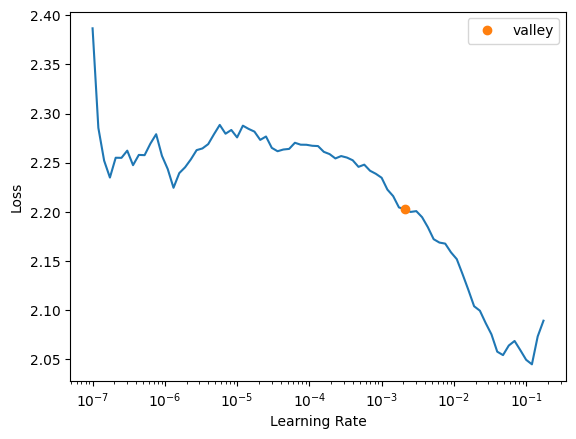

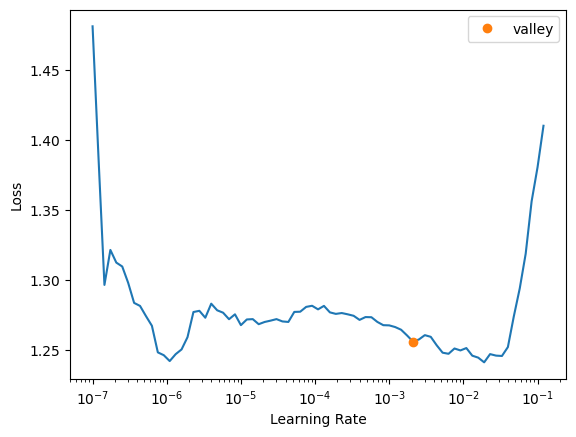

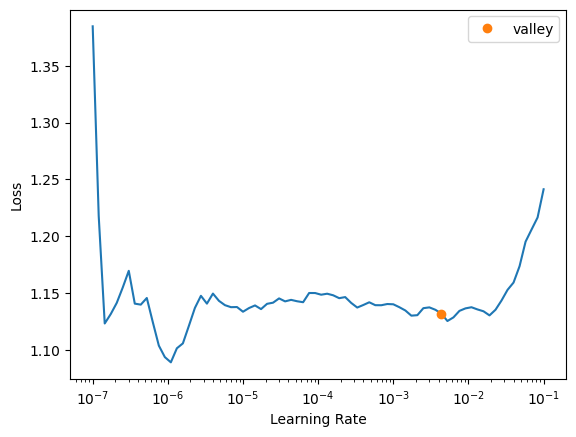

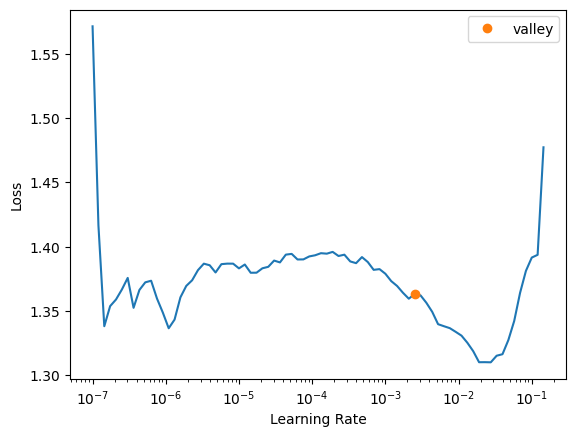

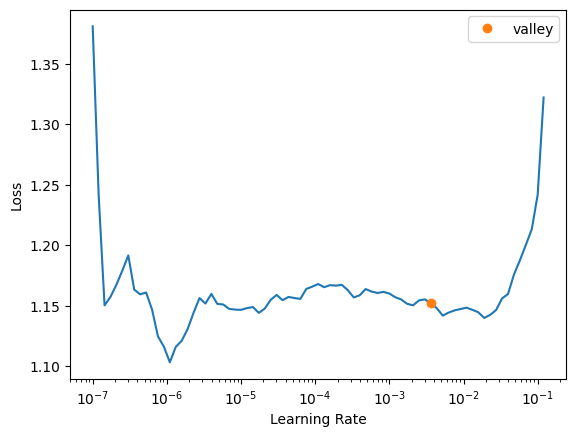

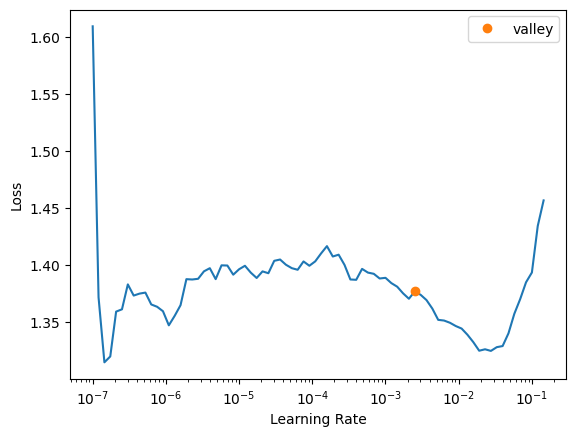

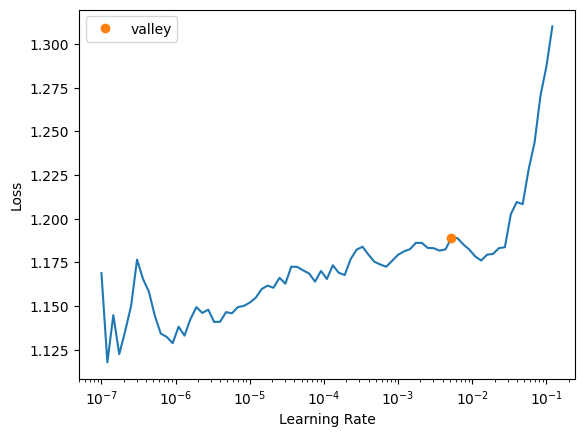

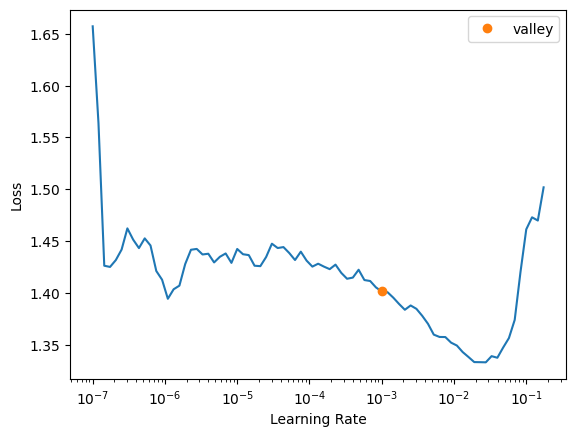

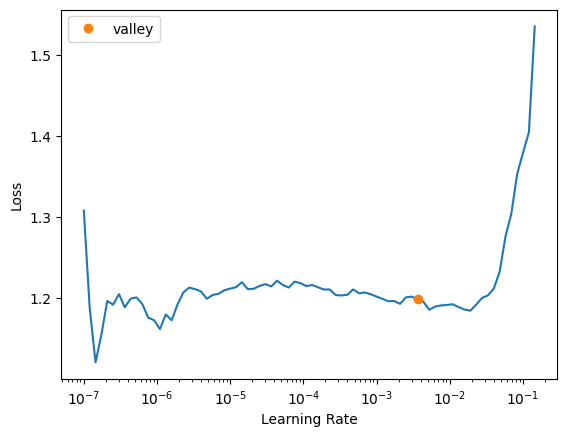

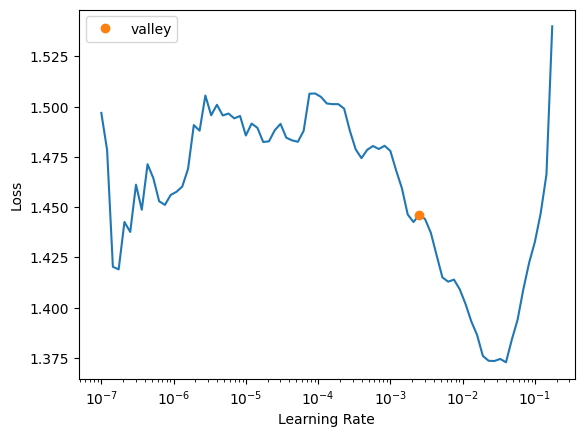

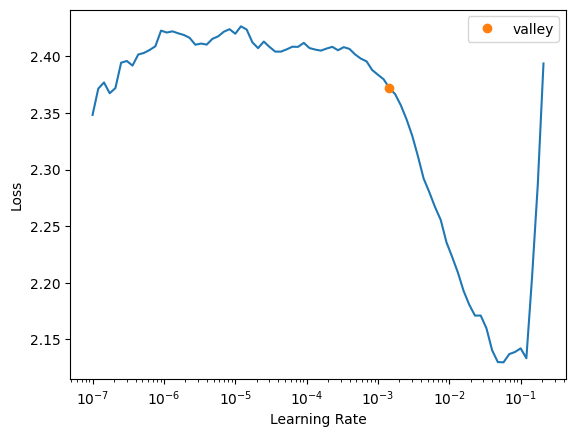

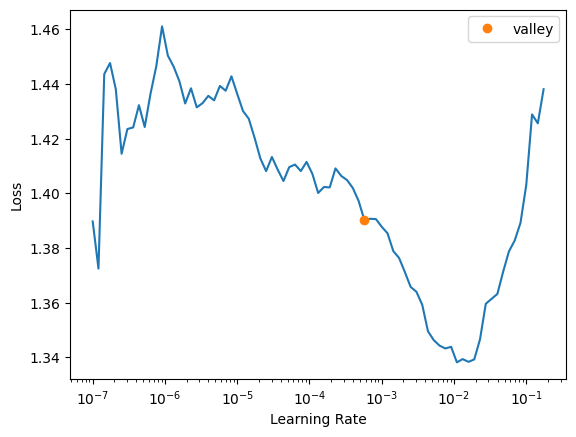

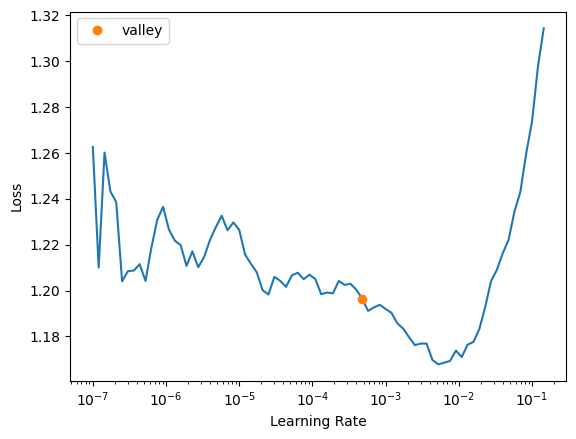

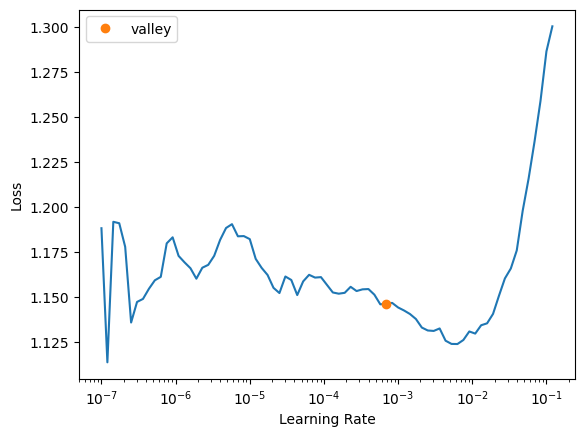

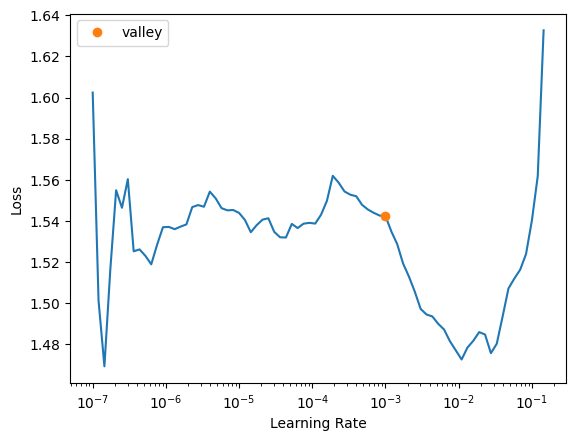

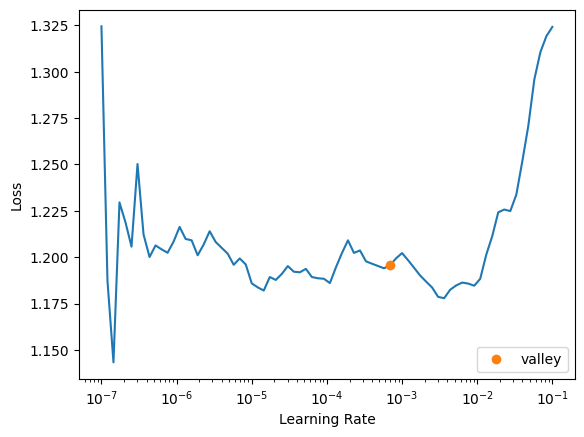

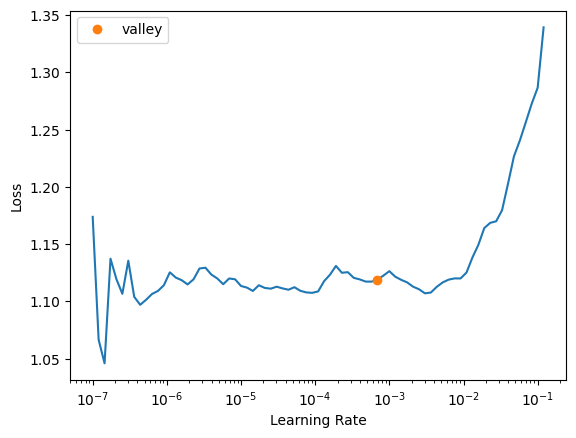

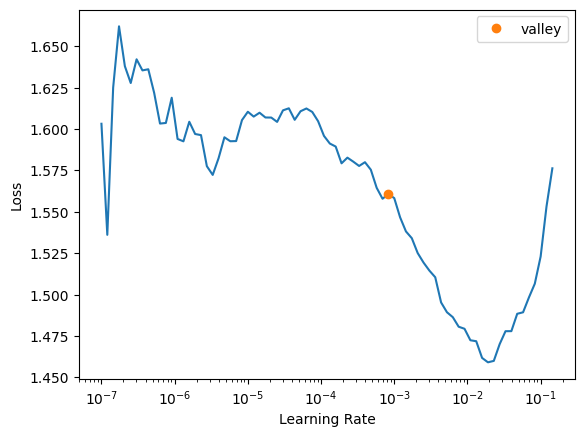

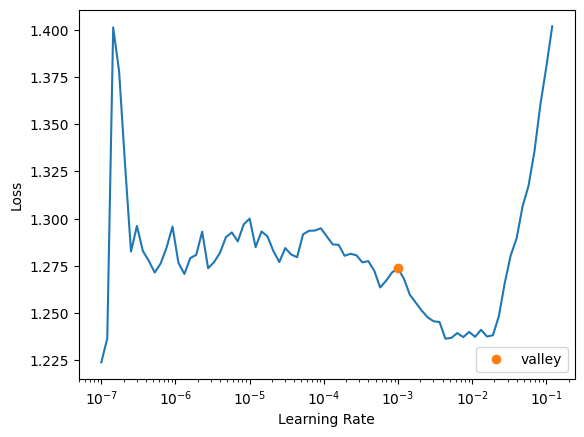

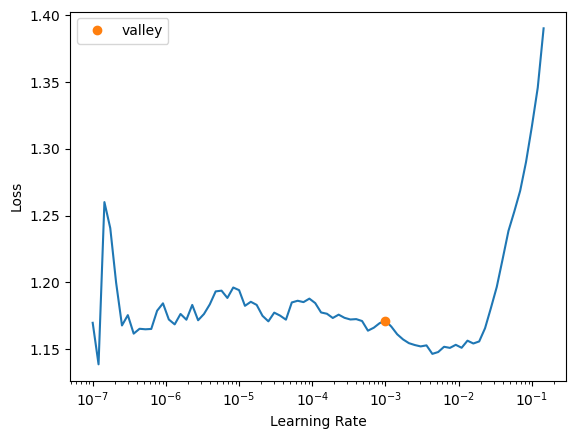

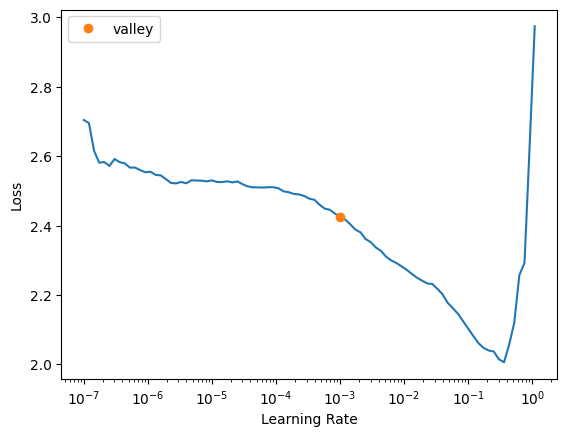

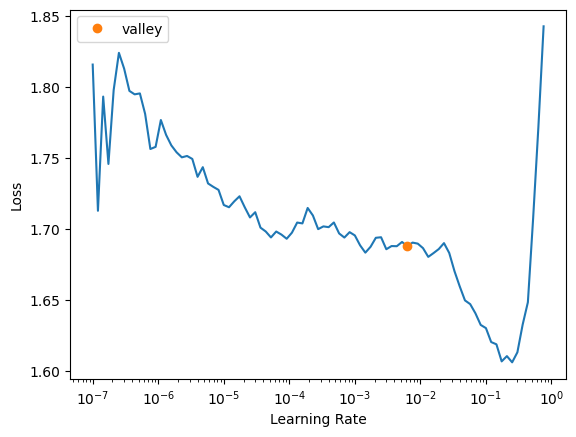

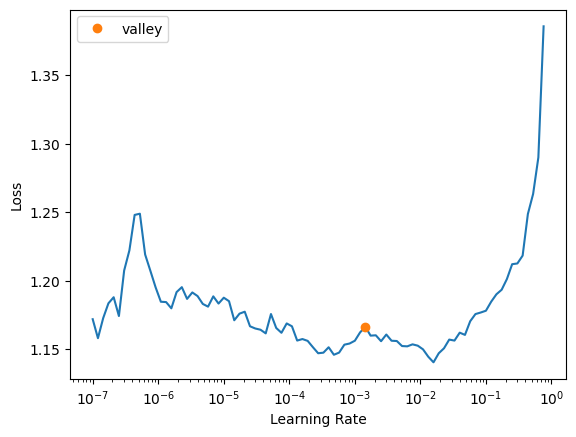

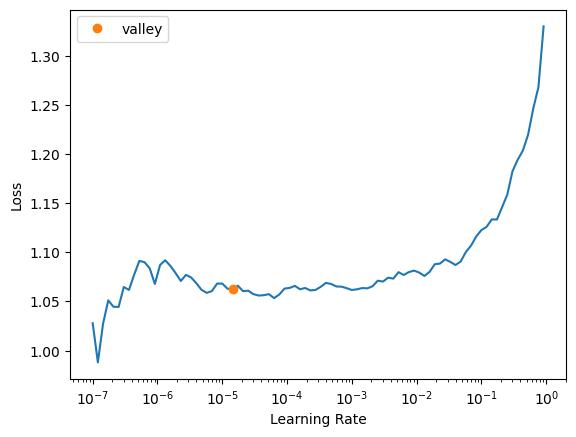

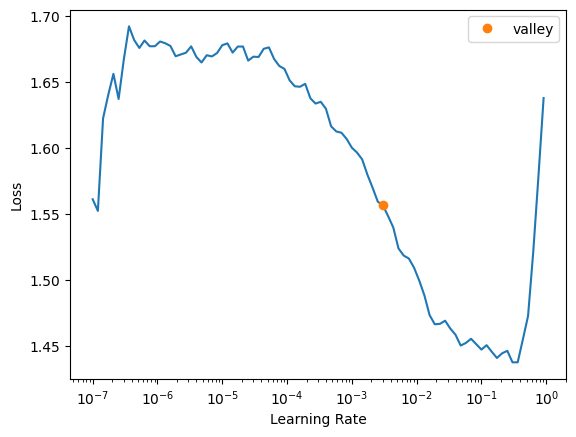

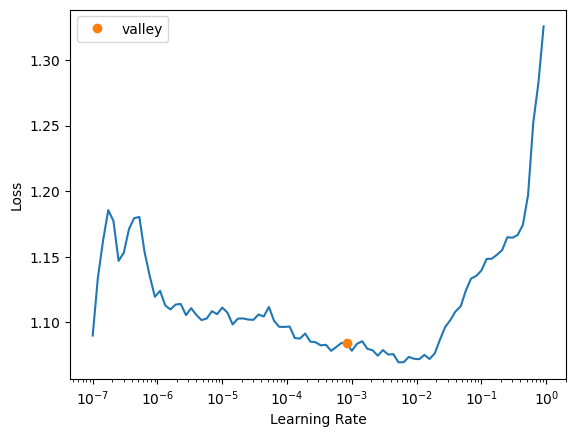

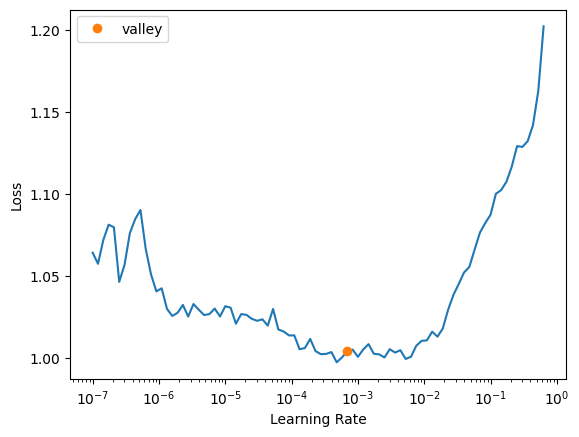

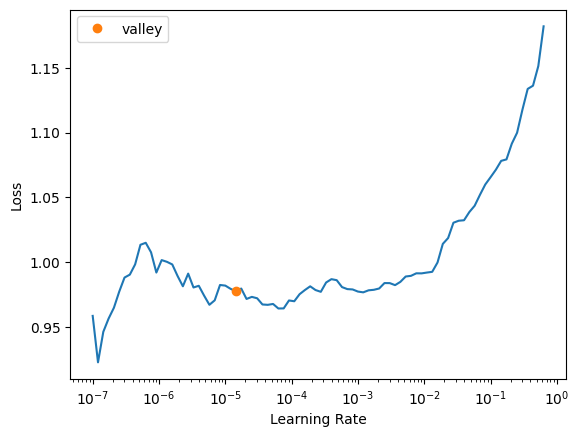

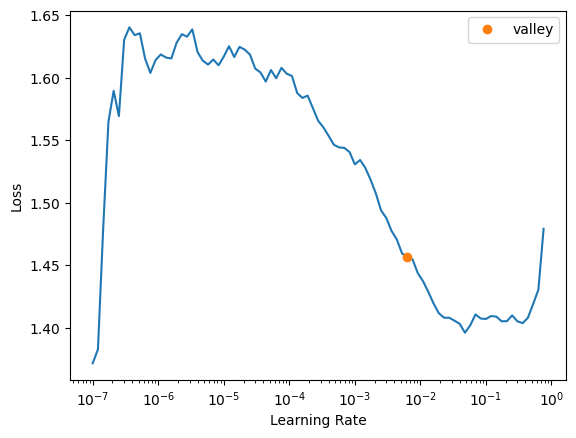

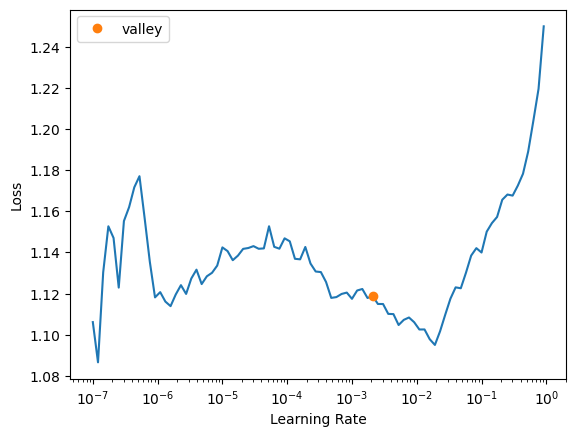

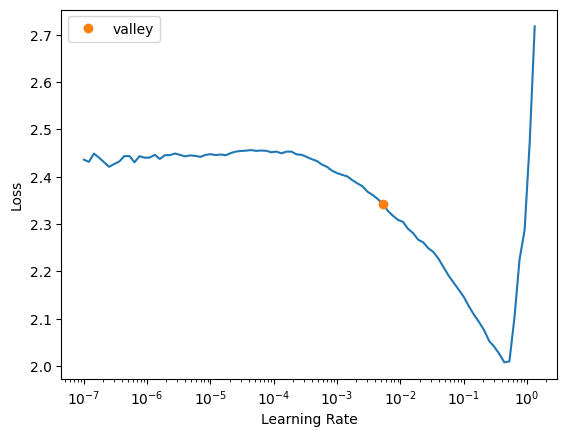

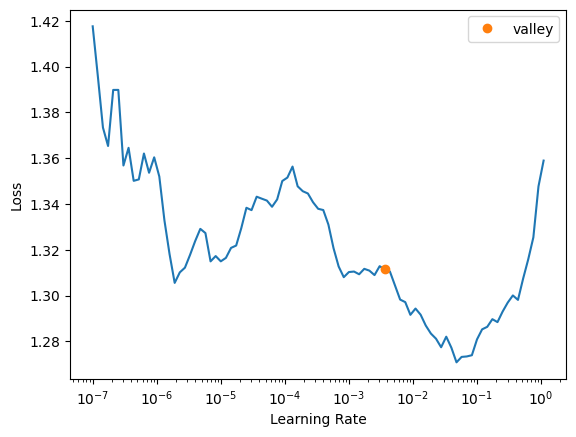

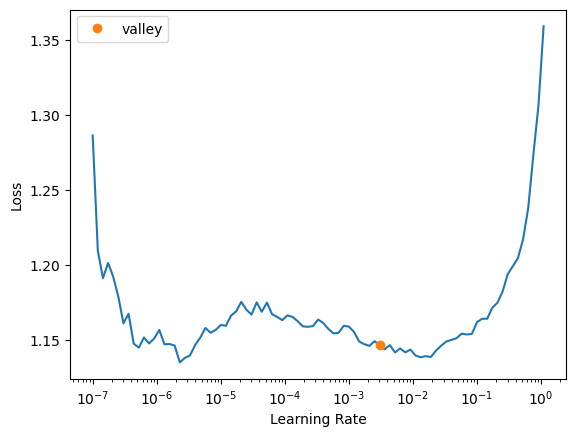

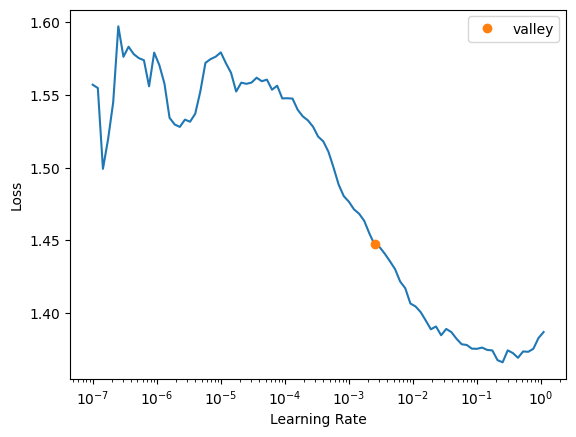

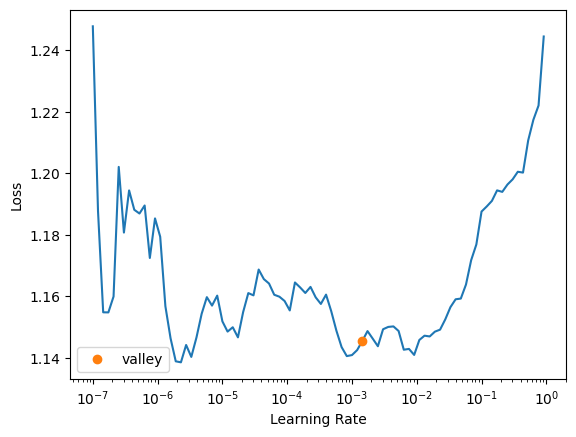

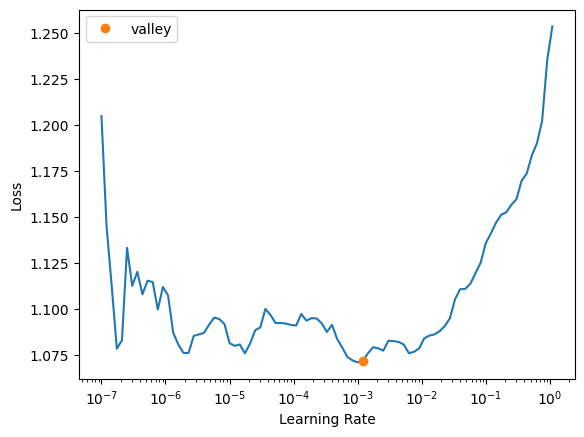

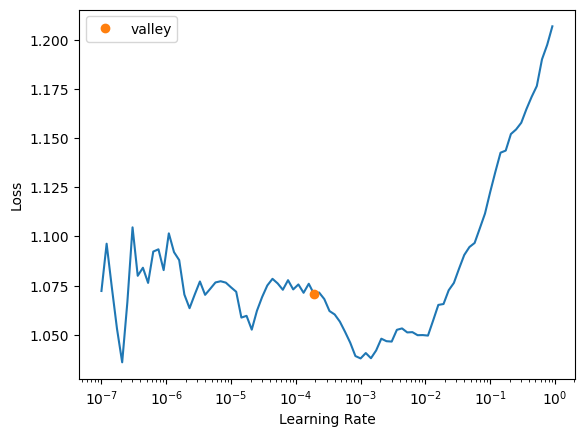

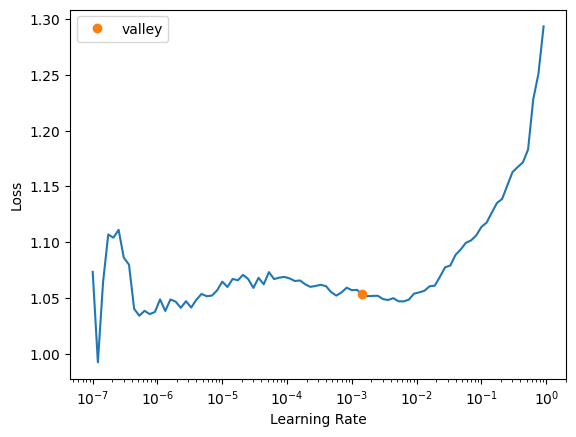

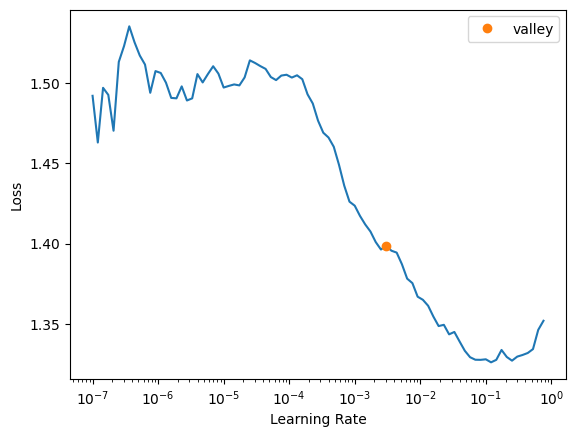

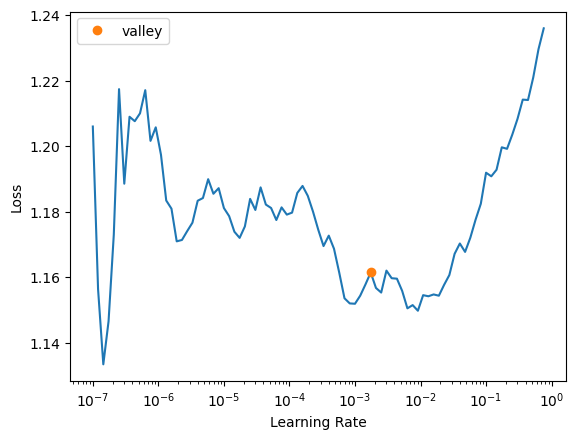

In [36]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'], f)
file_path = f'/notebooks/saved_models/SHADE-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'], f)


In [38]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [39]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [2.791630744934082, 2.362680435180664, 1.342529296875, 1.2478668689727783, 1.118810772895813, 1.1017541885375977, 1.08194100856781, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088, 1.067030429840088]
Validation error of SHADE-GD for 1 layers: [2.3776516914367676, 2.4640793800354004, 1.3558014631271362, 1.4431322813034058, 1.286297082901001, 1.2712719440460205, 1.2357109785079956, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287, 1.2452104091644287]
Difference: [-0.41397905  0.10139894  0.01327217  0.1952654

### SHADE-ILS-GD

deque([1, 1, 0.5919810216938362], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.111075520515442.
deque([1, 0.5919810216938362, 0.020440408559085525], maxlen=3)
deque([0.5919810216938362, 0.020440408559085525, 0.03119276288326932], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1185237169265747.
deque([0.020440408559085525, 0.03119276288326932, 0.004292274787636008], maxlen=3)
Reiniciado
deque([1, 1, 0.19535544666350788], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0960978269577026.
deque([1, 0.19535544666350788, 0.030057568464709965], maxlen=3)
deque([0.19535544666350788, 0.030057568464709965, 0.016052048973268285], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.082573652267456.
deque([0.030057568464709965, 0.016052048973268285, -0.0071728142007149494], maxlen=3)
Reiniciado
deque([1, 1, 0.13219636082162603], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1819058656692505.
deque([1, 0.13219636082162603, 0.02562606612931579], maxlen=3)
deque([0.13219636082162603, 0.02562606612931579, 0.01419861184673413], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.2061057090759277.
deque([0.02562606612931579, 0.01419861184673413, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.24595400877425433], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.137497901916504.
deque([1, 0.24595400877425433, 0.033906054631043445], maxlen=3)
deque([0.24595400877425433, 0.033906054631043445, 0.004780123481313813], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.12819242477417.
deque([0.033906054631043445, 0.004780123481313813, 0.0059963266975702895], maxlen=3)
Reiniciado
deque([1, 1, 0.2075865654759733], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1235108375549316.
deque([1, 0.2075865654759733, 0.015534372558087112], maxlen=3)
deque([0.2075865654759733, 0.015534372558087112, 0.022388702261448356], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1875320672988892.
deque([0.015534372558087112, 0.022388702261448356, 0.011285658924337775], maxlen=3)
Reiniciado
deque([1, 1, 0.6016783716947138], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1158859729766846.
deque([1, 0.6016783716947138, 0.006012278804733592], maxlen=3)
deque([0.6016783716947138, 0.006012278804733592, 0.020417538726363652], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0894513130187988.
deque([0.006012278804733592, 0.020417538726363652, 0.009023179036152152], maxlen=3)
Reiniciado
deque([1, 1, 0.20546590507042312], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.154355525970459.
deque([1, 0.20546590507042312, 0.017032336100482638], maxlen=3)
deque([0.20546590507042312, 0.017032336100482638, 0.02266902155958796], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1400998830795288.
deque([0.017032336100482638, 0.02266902155958796, 0.01742628811200083], maxlen=3)
Reiniciado
deque([1, 1, 0.32657520519116123], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.115937352180481.
deque([1, 0.32657520519116123, -0.009767718945569078], maxlen=3)
deque([0.32657520519116123, -0.009767718945569078, 0.010434713136570907], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0778506994247437.
deque([-0.009767718945569078, 0.010434713136570907, 0.019784230271385008], maxlen=3)
Reiniciado
deque([1, 1, 0.21308171794367733], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.16443932056427.
deque([1, 0.21308171794367733, 0.03619883898175645], maxlen=3)
deque([0.21308171794367733, 0.03619883898175645, -0.015258928269444428], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1605579853057861.
deque([0.03619883898175645, -0.015258928269444428, 0.01937831253205676], maxlen=3)
Reiniciado
deque([1, 1, 0.2507240750803823], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1202366352081299.
deque([1, 0.2507240750803823, -0.01630420321556249], maxlen=3)
deque([0.2507240750803823, -0.01630420321556249, 0.015626874693219724], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1236422061920166.
deque([-0.01630420321556249, 0.015626874693219724, 0.003534116877979878], maxlen=3)
Reiniciado
deque([1, 1, 0.6419616707061715], maxlen=3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


Better model found at epoch 0 with valid_loss value: 1.0144661664962769.
deque([1, 0.6419616707061715, -0.004274814495743521], maxlen=3)
deque([0.6419616707061715, -0.004274814495743521, 0.014515496317955394], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9664847254753113.
deque([-0.004274814495743521, 0.014515496317955394, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.4891989902232858], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9255595207214355.
deque([1, 0.4891989902232858, 0.03044768837053121], maxlen=3)
deque([0.4891989902232858, 0.03044768837053121, 0.007562405141107122], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8702462911605835.
deque([0.03044768837053121, 0.007562405141107122, 0.0037138266758481517], maxlen=3)
Reiniciado
deque([1, 1, 0.3078171383155911], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0373432636260986.
deque([1, 0.3078171383155911, 0.016793291566502423], maxlen=3)
deque([0.3078171383155911, 0.016793291566502423, 0.04692242459698737], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0078957080841064.
deque([0.016793291566502423, 0.04692242459698737, -0.0030204692667692066], maxlen=3)
Reiniciado
deque([1, 1, 0.28274614655743563], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0058891773223877.
deque([1, 0.28274614655743563, 0.0149594955868173], maxlen=3)
deque([0.28274614655743563, 0.0149594955868173, 0.0019456233357367074], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9447216391563416.
deque([0.0149594955868173, 0.0019456233357367074, 0.05378422176163619], maxlen=3)
deque([0.0019456233357367074, 0.05378422176163619, -0.010290898738775435], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9116172194480896.
deque([0.05378422176163619, -0.010290898738775435, 0.014482127955194669], maxlen=3)
deque([-0.010290898738775435, 0.014482127955194669, 0.009110867718662916], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.0441160202026367.
deque([1, 1, 0.35350058535029677], maxlen=3)
deque([1, 1, 0.5985794296342678], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1189745664596558.
deque([1, 0.5985794296342678, 0.0009806554462379986], maxlen=3)
deque([0.5985794296342678, 0.0009806554462379986, 0.00406308168990004], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1173063516616821.
deque([0.0009806554462379986, 0.00406308168990004, 0.030487509835189573], maxlen=3)
Reiniciado
deque([1, 1, 0.36187841618842487], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.143310785293579.
deque([1, 0.36187841618842487, 0.014587840419729055], maxlen=3)
deque([0.36187841618842487, 0.014587840419729055, 0.07359449684637864], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0845040082931519.
deque([0.014587840419729055, 0.07359449684637864, 0.01745061157714904], maxlen=3)
deque([0.07359449684637864, 0.01745061157714904, 0.019523362549958], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0882048606872559.
deque([0.01745061157714904, 0.019523362549958, -0.007066969039776687], maxlen=3)
Reiniciado
deque([1, 1, 0.08793134421698441], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0835230350494385.
deque([1, 0.08793134421698441, 0.05118452169548428], maxlen=3)
deque([0.08793134421698441, 0.05118452169548428, 0.02518468022848493], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.025206446647644.
deque([0.05118452169548428, 0.02518468022848493, 0.018328873144696202], maxlen=3)
deque([0.02518468022848493, 0.018328873144696202, 0.010691689894318918], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.0610524415969849.
deque([1, 1, 0.16886727524307932], maxlen=3)
deque([1, 0.16886727524307932, 0.06788694920216286], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0419524908065796.
deque([0.16886727524307932, 0.06788694920216286, 0.01414763849867229], maxlen=3)
deque([0.06788694920216286, 0.01414763849867229, 0.020114052886212735], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.132613182067871.
deque([0.01414763849867229, 0.020114052886212735, -0.003267732021722627], maxlen=3)
Reiniciado


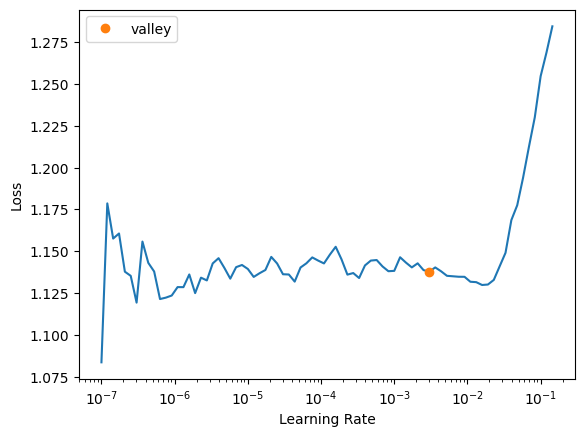

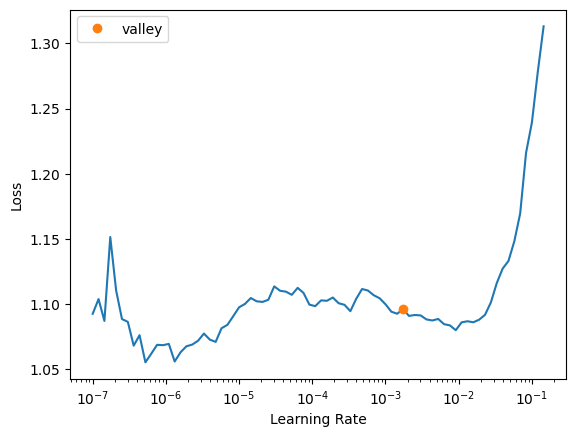

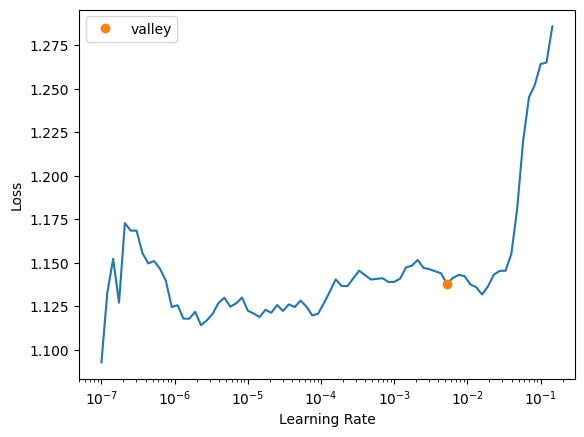

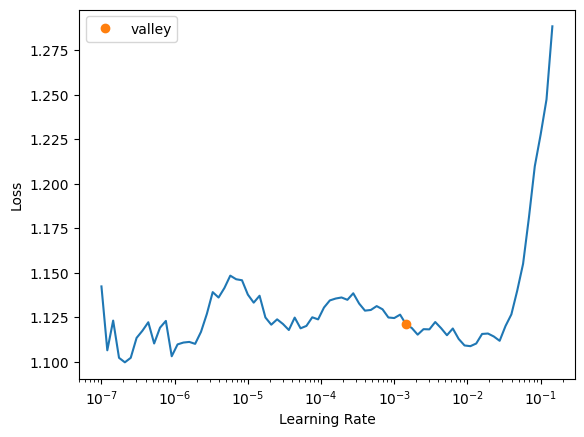

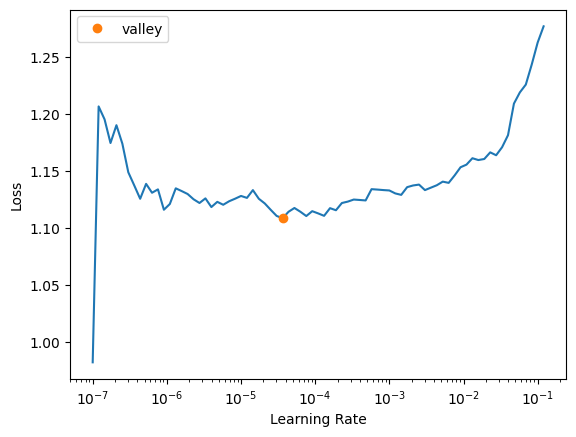

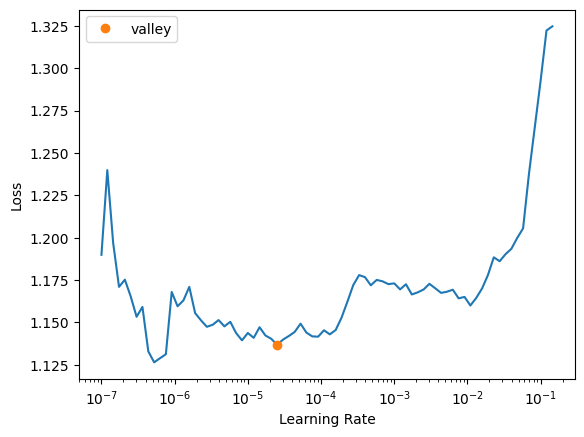

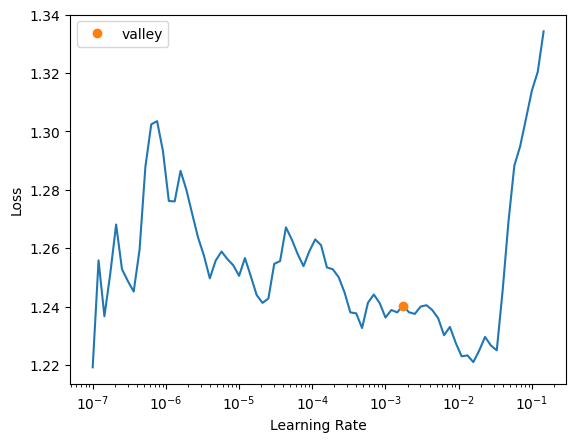

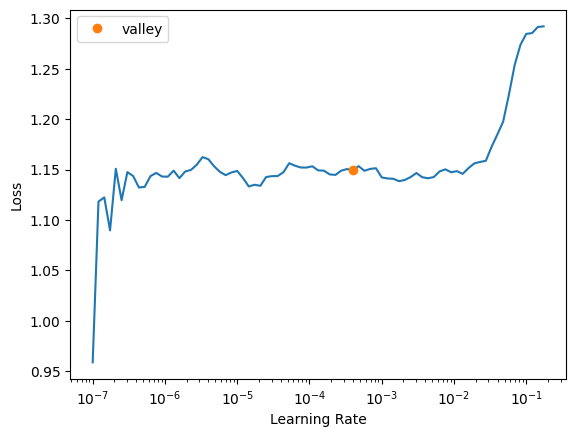

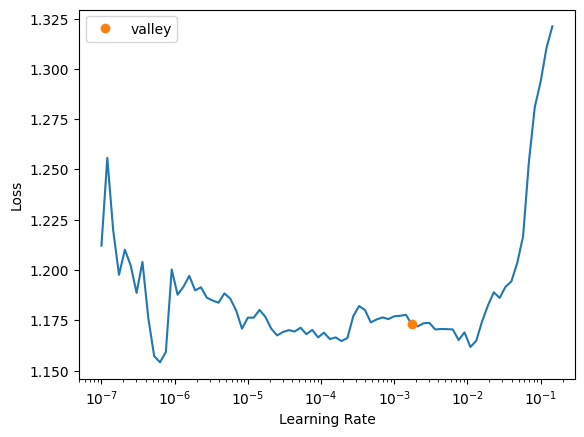

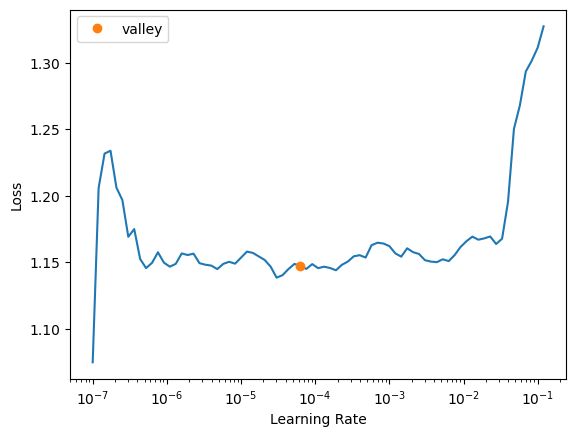

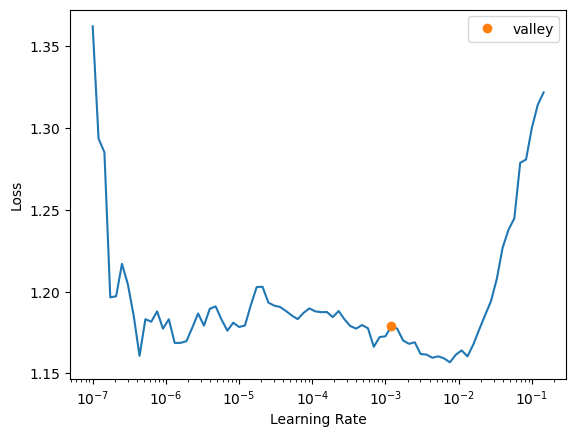

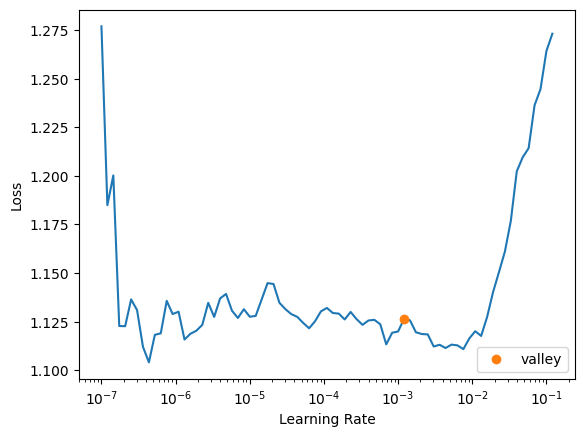

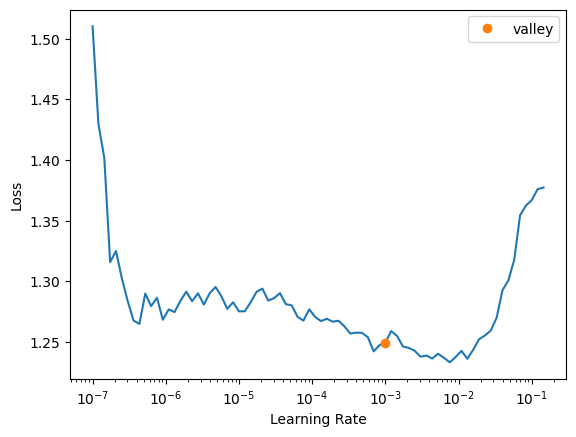

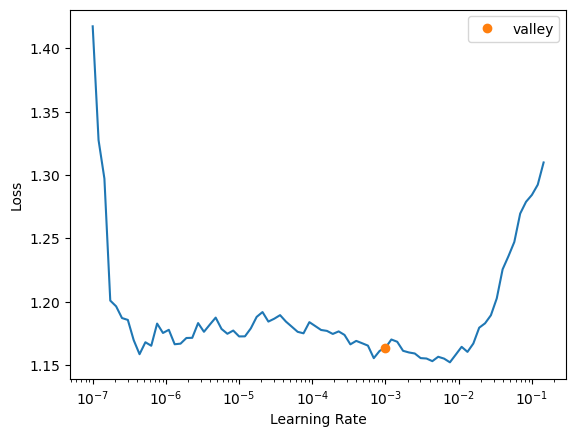

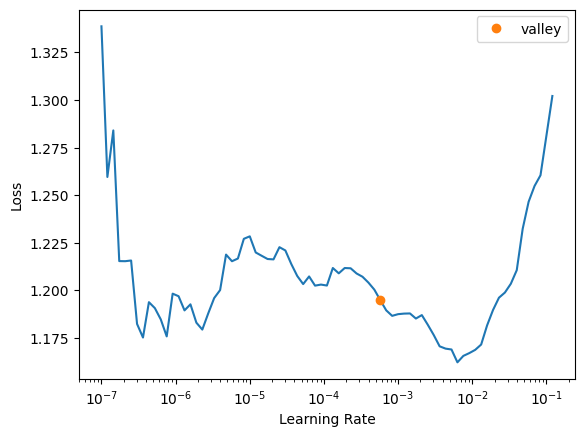

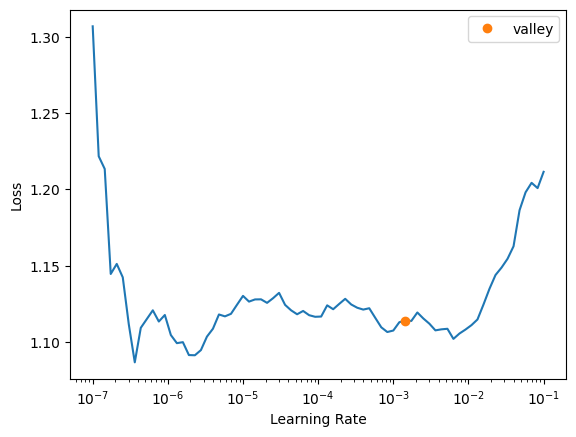

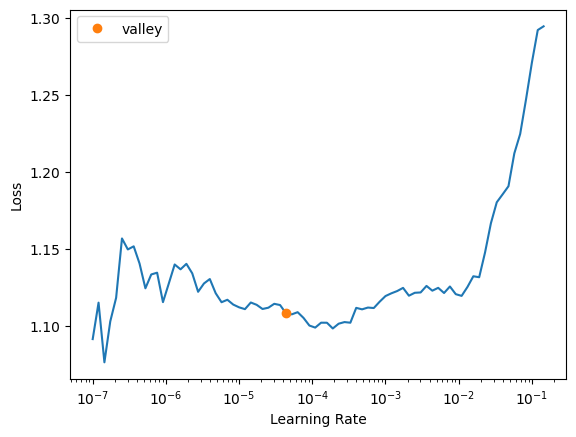

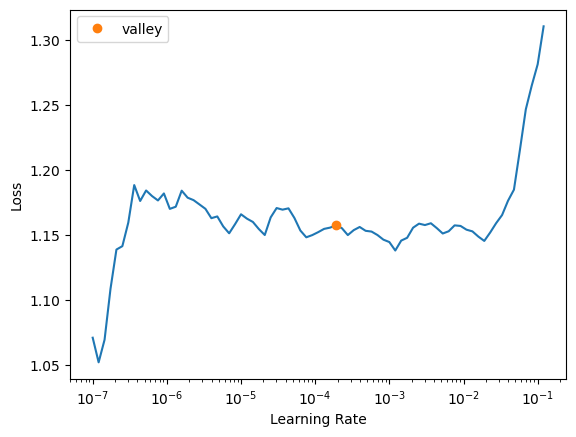

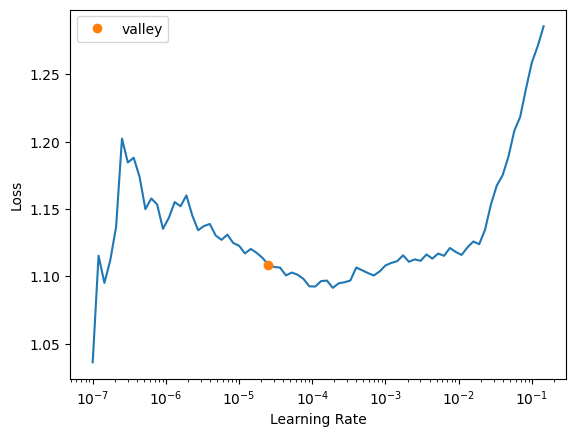

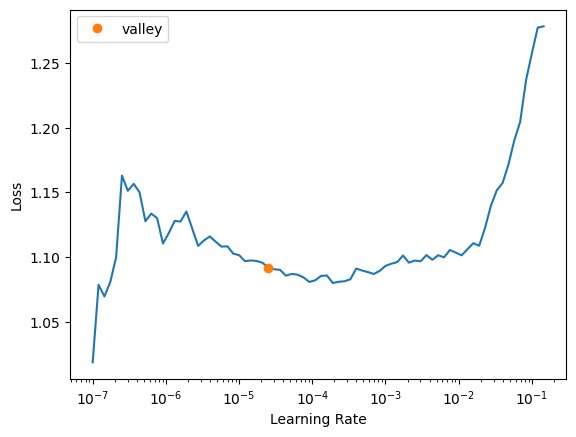

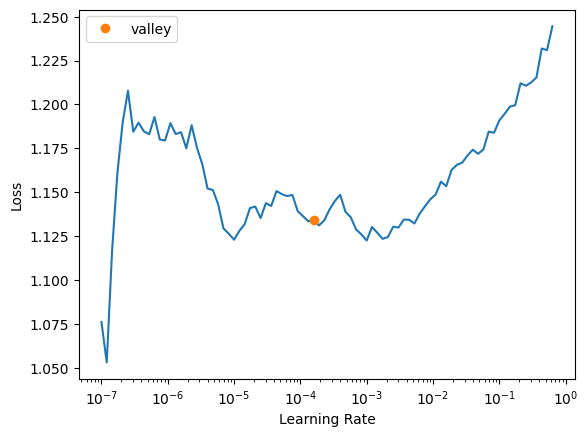

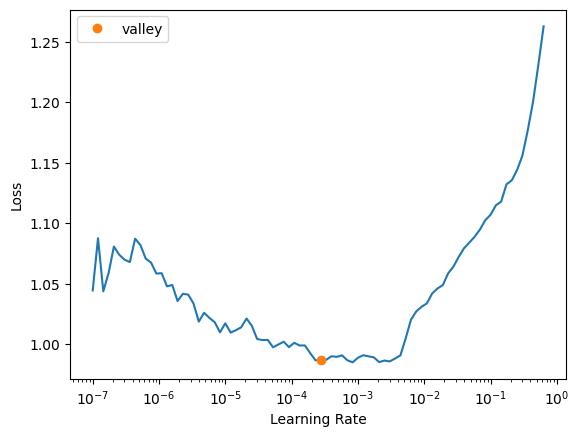

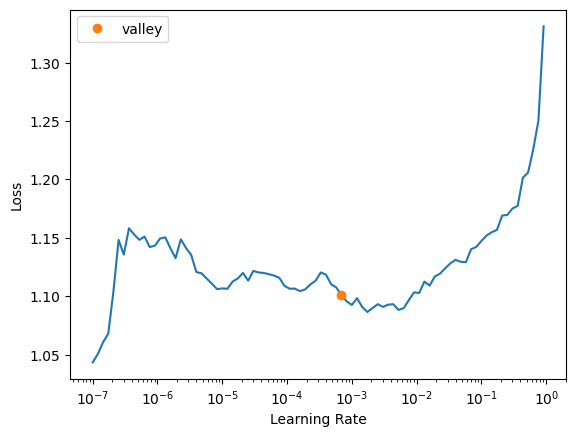

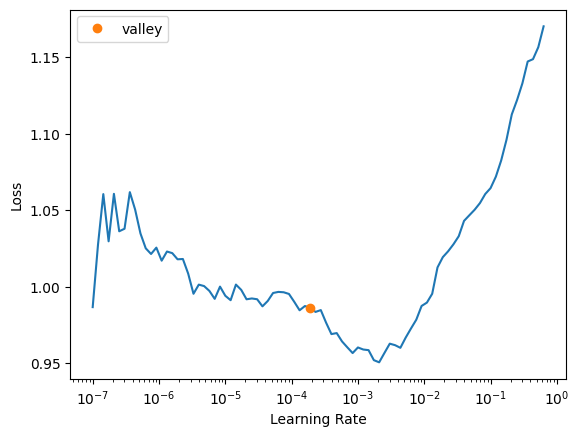

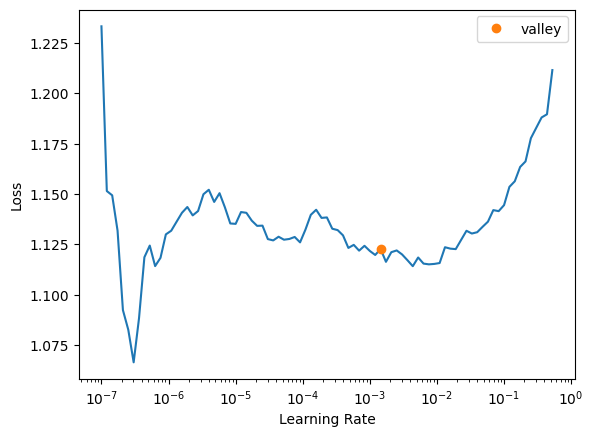

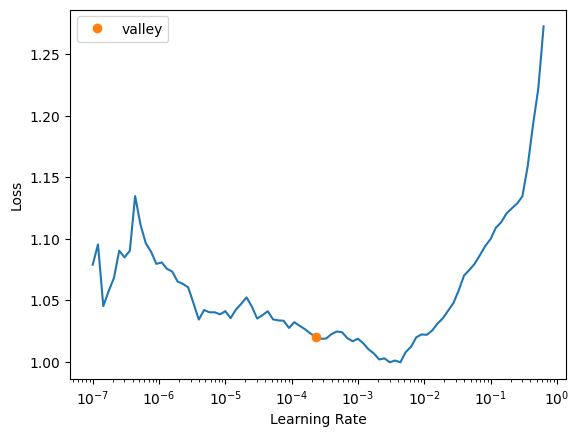

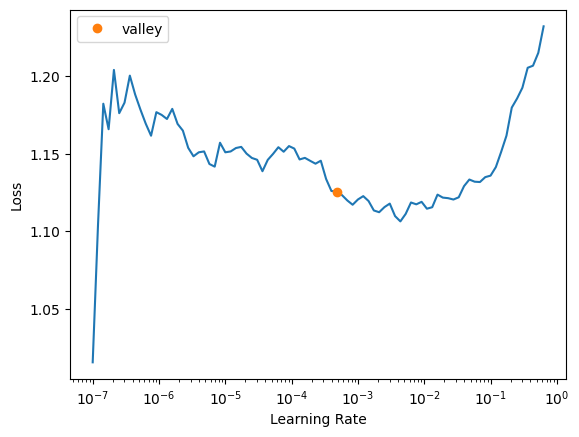

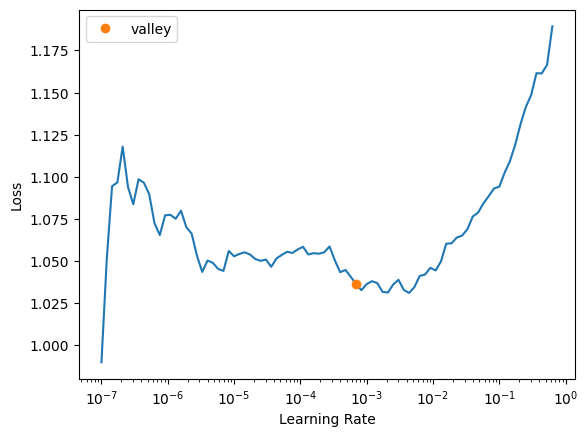

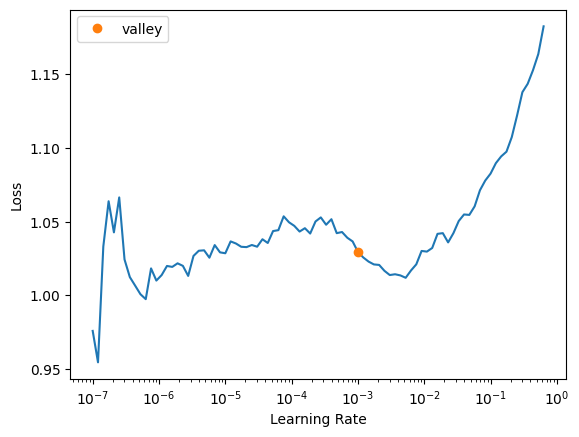

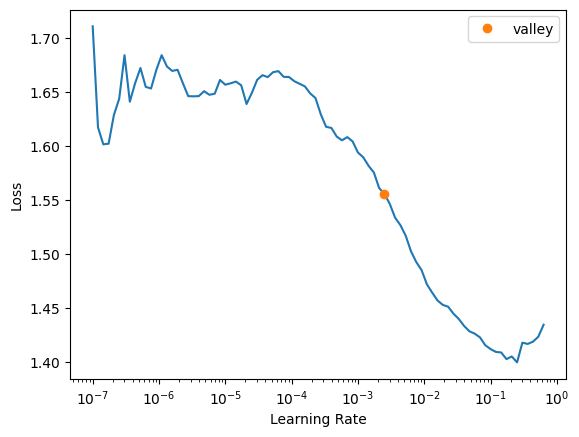

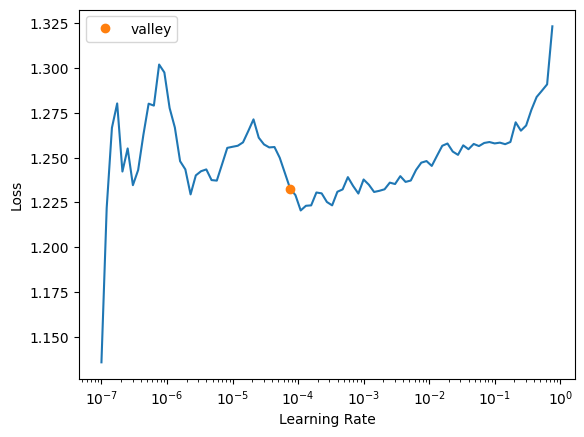

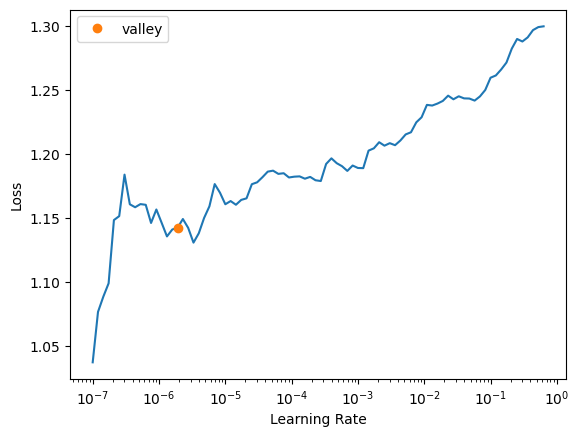

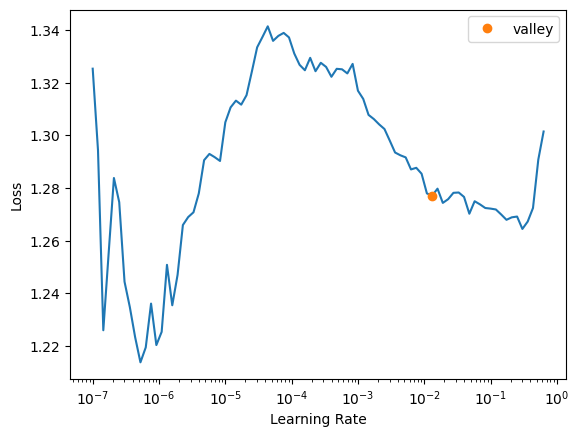

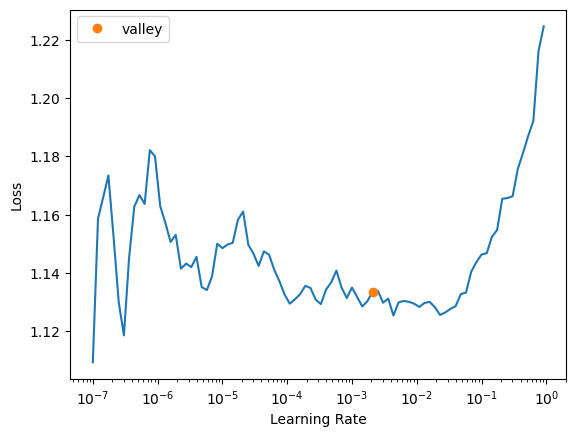

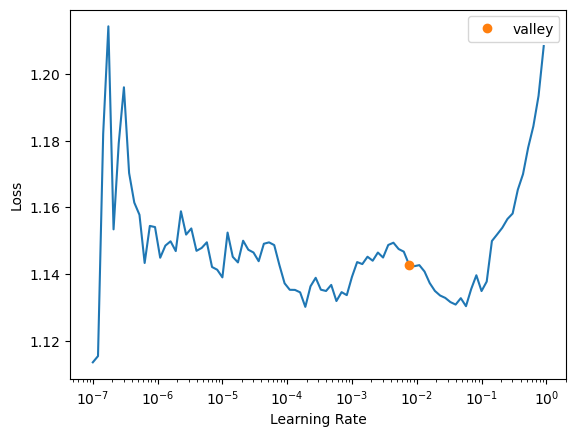

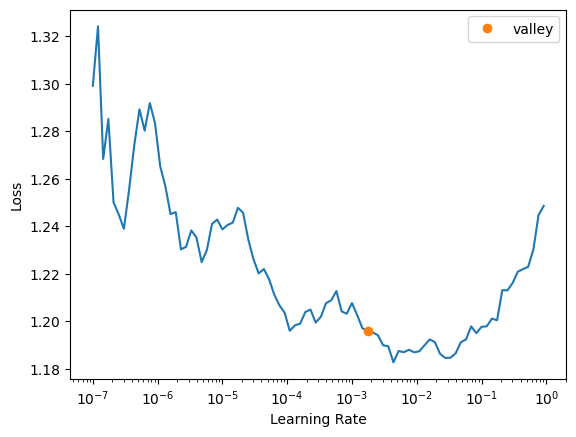

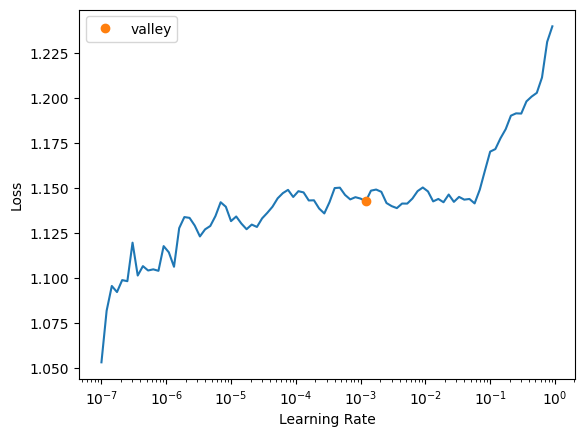

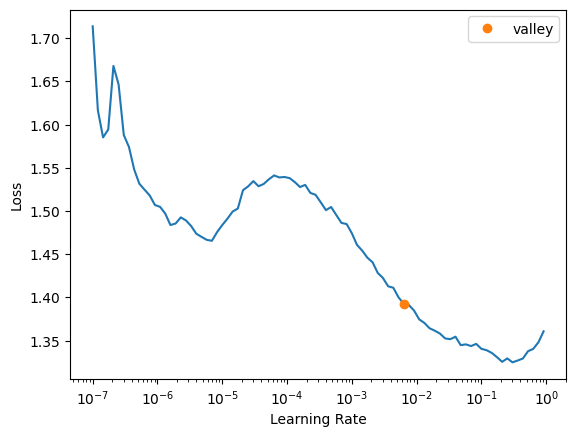

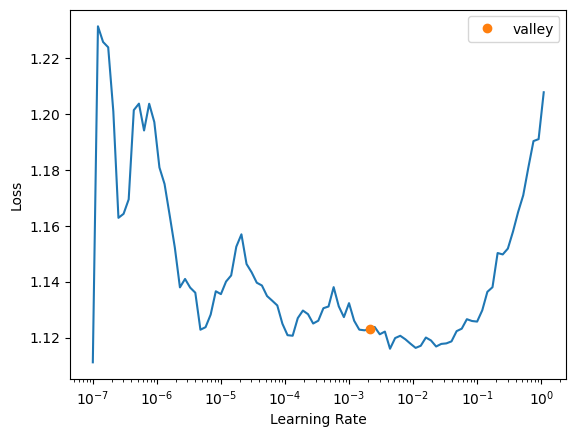

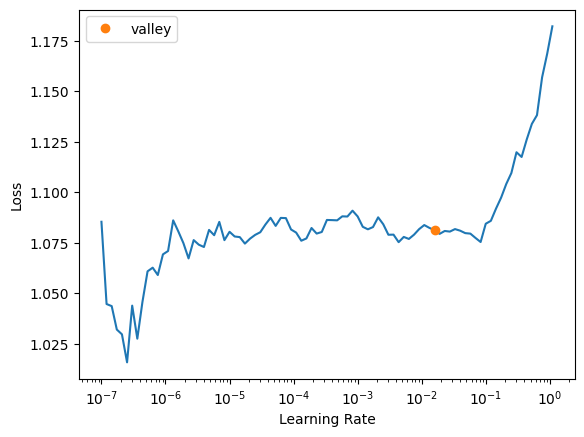

In [37]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'], f)
file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'], f)


In [40]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [41]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [2.791630744934082, 1.139038324356079, 1.1157559156417847, 1.0809524059295654, 1.0763126611709595, 1.0763126611709595, 1.0763126611709595, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226, 1.068424105644226]
Validation error of SHADE-ILS-GD for 1 layers: [2.3776516914367676, 1.2928285598754883, 1.2994493246078491, 1.2612444162368774, 1.2280851602554321, 1.2280851602554321, 1.2280851602554321, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392, 1.1840530633926392]
Difference: [-0.41397905  0.15379024  0.18369341  0.18029201  0.1517725   0.151772

### Save or load

### Comparison between MH

In [ ]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [ ]:
#Calculate accuracy and balanced accuracy
bal_acc = {}
for mh in algs:
  bal_acc[mh] = {}
  for layer in n_layers:
    bal_acc[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    start = time.perf_counter()
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      bal_acc[mh][layer].append(utilsTFG.balanced_accuracy_func(preds, targs))
    end = time.perf_counter()
    #time_full_mh[mh][layer]+= end-start

<Figure size 1200x600 with 0 Axes>

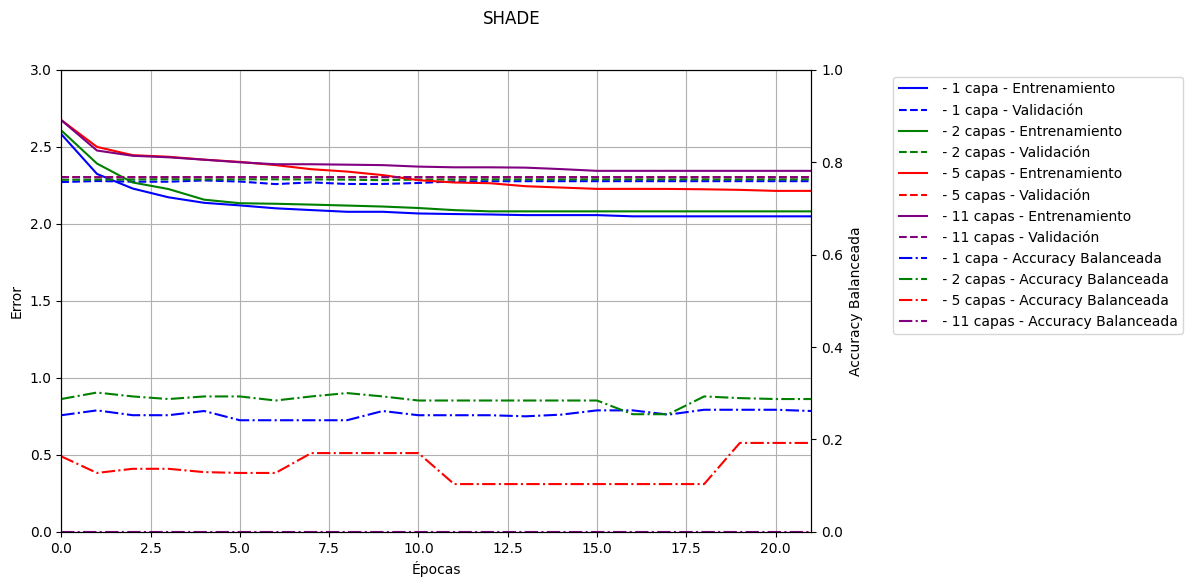

<Figure size 1200x600 with 0 Axes>

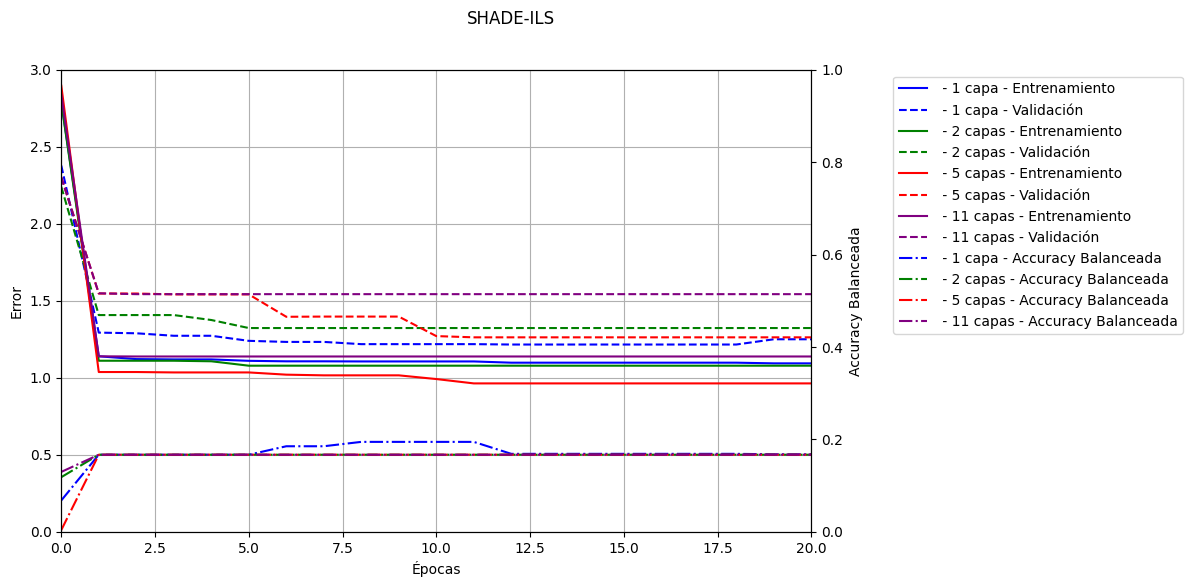

<Figure size 1200x600 with 0 Axes>

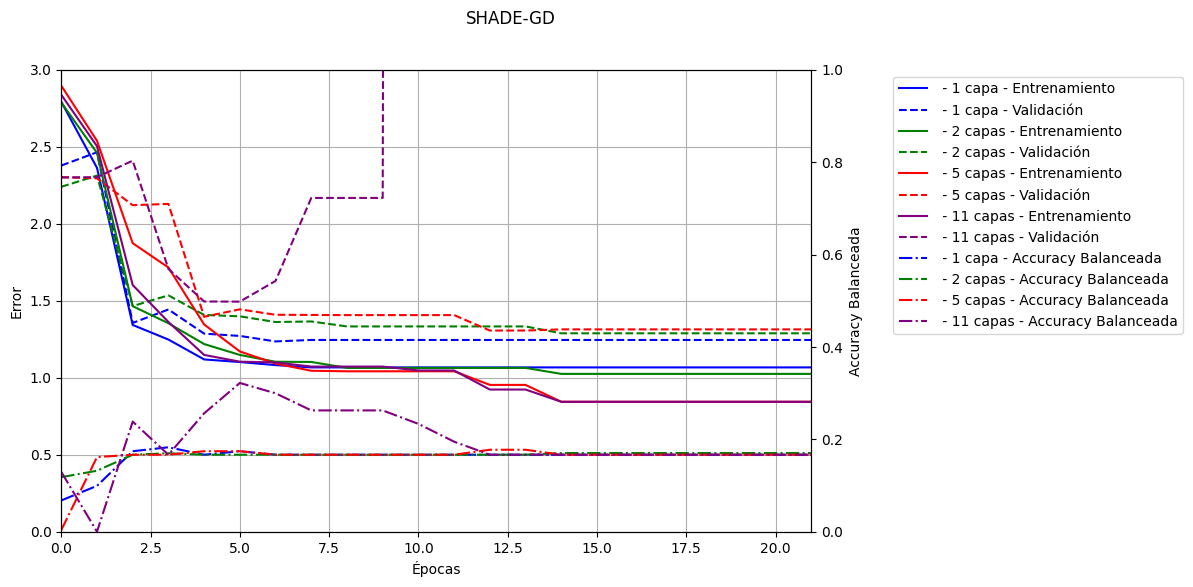

<Figure size 1200x600 with 0 Axes>

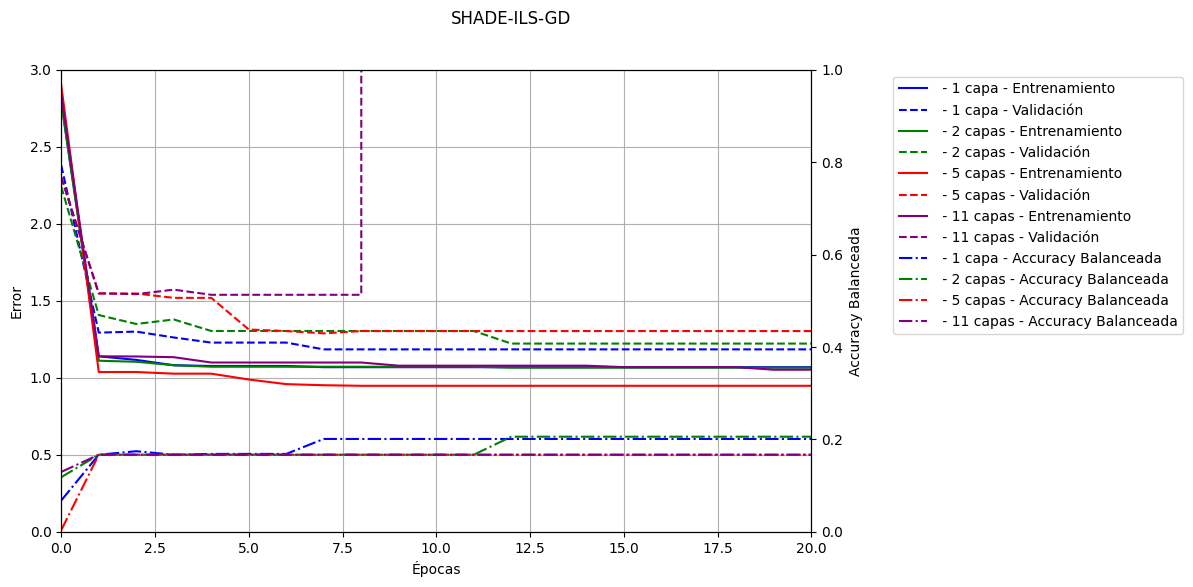

In [41]:
#Comparing the different layers version of the same MH
names= ['1 capa', '2 capas', '5 capas', '11 capas']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], bal_acc[alg],  lim=3, layers = n_layers, names=names, title=f'{alg}', metric='BalAcc')

<Figure size 1200x600 with 0 Axes>

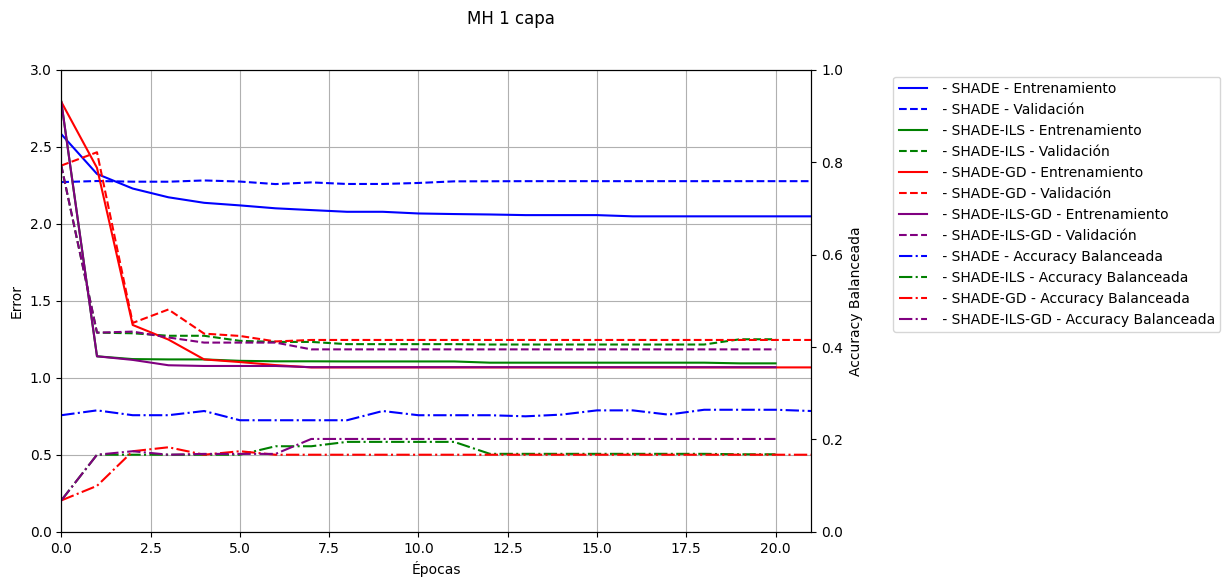

<Figure size 1200x600 with 0 Axes>

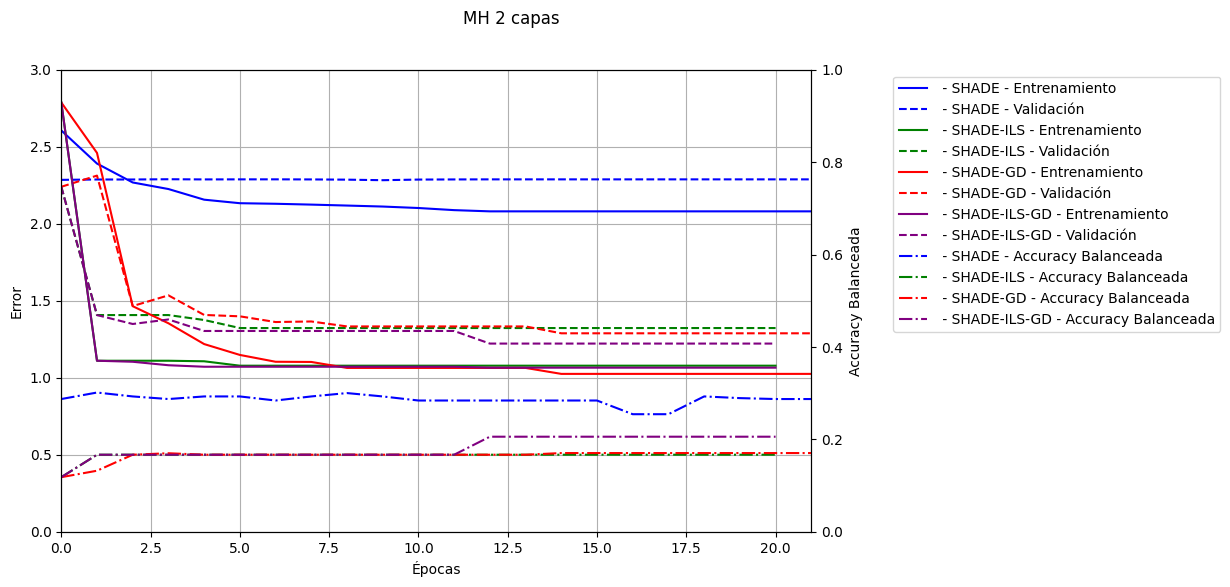

<Figure size 1200x600 with 0 Axes>

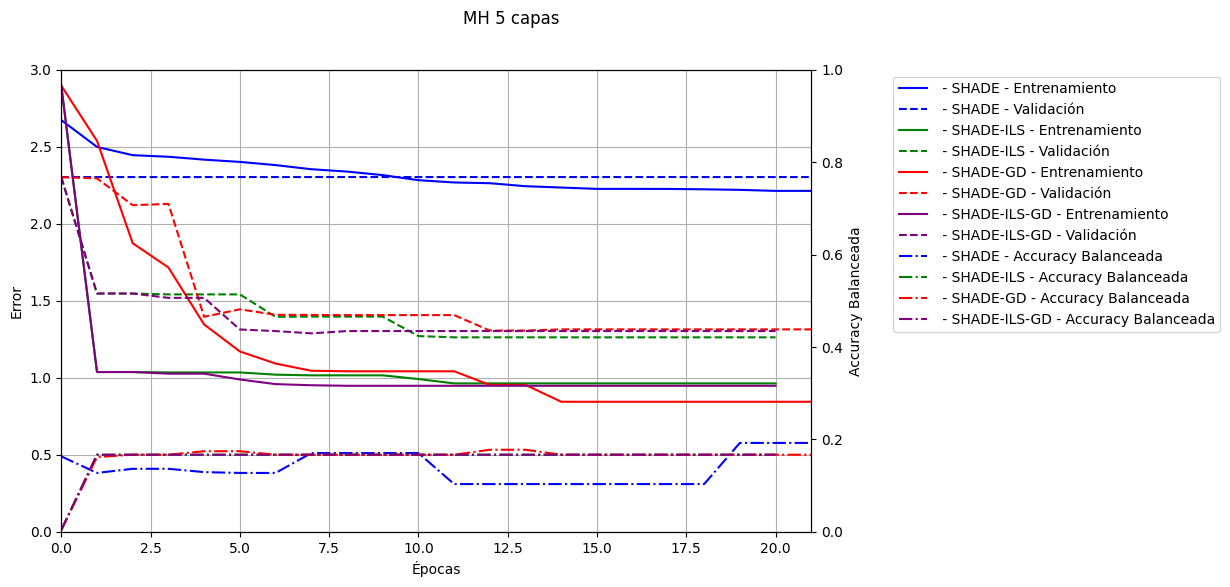

<Figure size 1200x600 with 0 Axes>

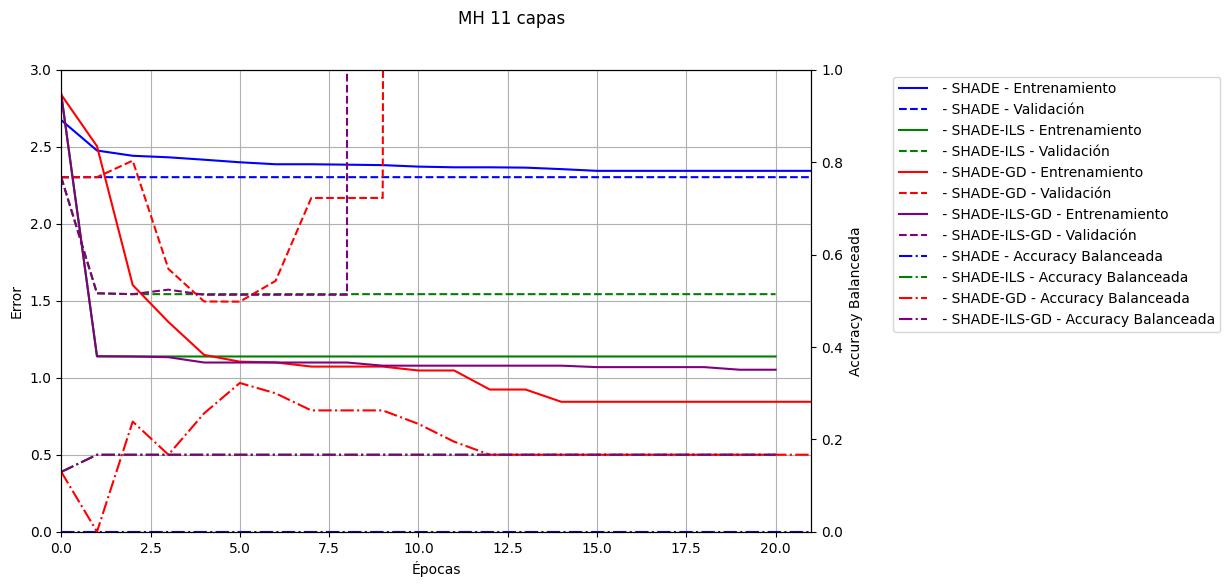

In [42]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
acc = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  acc[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    acc[layer][alg] = bal_acc[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  c = 'capa' if layer==1 else 'capas'
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], acc[layer], lim=3, layers = names, names=names, title=f'MH {layer} {c}', metric='BalAcc')

### Generalization

In [42]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, Balanced accuracy: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 2.475497007369995, Balanced accuracy: 0.29510505517415636


Optimizer: SHADE, Layers: 2, Loss: 2.3152012825012207, Balanced accuracy: 0.21359447605290463


Optimizer: SHADE, Layers: 5, Loss: 2.3044545650482178, Balanced accuracy: 0.04198326366274818


Optimizer: SHADE, Layers: 11, Loss: 2.302215576171875, Balanced accuracy: 0.0


Optimizer: SHADE-ILS, Layers: 1, Loss: 1.2348041534423828, Balanced accuracy: 0.20112796688444298


Optimizer: SHADE-ILS, Layers: 2, Loss: 1.3400614261627197, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-ILS, Layers: 5, Loss: 1.4047969579696655, Balanced accuracy: 0.16690219253168892


Optimizer: SHADE-ILS, Layers: 11, Loss: 1.50906503200531, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-GD, Layers: 1, Loss: 1.304402232170105, Balanced accuracy: 0.17082048646796846


Optimizer: SHADE-GD, Layers: 2, Loss: 1.4862124919891357, Balanced accuracy: 0.1917692736567049


Optimizer: SHADE-GD, Layers: 5, Loss: 1.4945422410964966, Balanced accuracy: 0.2025794948456819


Optimizer: SHADE-GD, Layers: 11, Loss: 3.982316255569458, Balanced accuracy: 0.2111042477110047


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 1.2240078449249268, Balanced accuracy: 0.226005112114246


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 1.3995575904846191, Balanced accuracy: 0.3061116730038483


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 1.3283398151397705, Balanced accuracy: 0.16632408359027065


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 1.4957664012908936, Balanced accuracy: 0.16666666666666666


## Time comparison

In [38]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 708.6061 seconds
Time consumed by SHADE training with 2 layers: 770.0768 seconds
Time consumed by SHADE training with 5 layers: 969.4619 seconds
Time consumed by SHADE training with 11 layers: 1941.4434 seconds
Time consumed by SHADE-ILS training with 1 layers: 798.4677 seconds
Time consumed by SHADE-ILS training with 2 layers: 864.9306 seconds
Time consumed by SHADE-ILS training with 5 layers: 1108.0623 seconds
Time consumed by SHADE-ILS training with 11 layers: 2390.9100 seconds
Time consumed by SHADE-GD training with 1 layers: 800.2464 seconds
Time consumed by SHADE-GD training with 2 layers: 854.4639 seconds
Time consumed by SHADE-GD training with 5 layers: 1096.9969 seconds
Time consumed by SHADE-GD training with 11 layers: 2096.5774 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 799.4138 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 867.9949 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 

In [33]:
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')

Time consumed by SHADE training with 1 layers: 720.734 seconds
Time consumed by SHADE training with 2 layers: 783.917 seconds
Time consumed by SHADE training with 5 layers: 983.024 seconds
Time consumed by SHADE training with 11 layers: 1958.819 seconds
Time consumed by SHADE-ILS training with 1 layers: 800.998 seconds
Time consumed by SHADE-ILS training with 2 layers: 867.628 seconds
Time consumed by SHADE-ILS training with 5 layers: 1111.359 seconds
Time consumed by SHADE-ILS training with 11 layers: 2395.200 seconds
